# Combined Electricity & Weather EDA

This notebook consolidates the global exploratory analysis from `data_loader.py` with the per-meter tooling from `per_meter_eda.py`, and extends it with intra-meter weekly diagnostics.


## Notebook Guide

- Configure `DATA_PATH` below to point at the merged electricity/weather dataset.
- Helper utilities keep track of column naming differences (upper vs lower case).
- Run the notebook sequentially so that downstream cells reuse shared tables.


In [1]:
import numpy as np
import pandas as pd
import re
from pandas.api.types import DatetimeTZDtype

from pathlib import Path
from typing import Dict, Iterable, List, Optional

import matplotlib.pyplot as plt

try:
    import seaborn as sns
except ImportError:
    sns = None

try:
    from IPython.display import display
except ImportError:
    display = print  # type: ignore[arg-type]

if sns is not None:
    sns.set_theme(style="whitegrid")

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 4)


In [2]:
# Update this list if your dataset lives elsewhere.
DEFAULT_DATA_PATHS = [
    Path(r"C:\Users\Owner\honours_project\datasets\original_data.csv"),
]

DATA_PATH = next((path for path in DEFAULT_DATA_PATHS if path.exists()), None)

# if DATA_PATH is None:
#     DATA_PATH = Path("/absolute/path/to/merged_electricity_weather.parquet")
#     print("Set DATA_PATH to the merged electricity/weather dataset before running the next cell.")
# else:
#     print(f"Using dataset at: {DATA_PATH.resolve()}")


In [3]:
DROP_CANDIDATES = [
    "ref",
    "row",
    "quarter",
    "aggregate_year",
    "aggregate_month",
    "aggregate_day",
    "aggregate_hour",
    "period_over_which_rainfall_was_measured_days",
    "days_of_accumulation_of_maximum_temperature",
    "days_of_accumulation_of_minimum_temperature",
]

COLUMN_ALIASES: Dict[str, Iterable[str]] = {
    "meter": ("meter_ui", "meter", "meter_id"),
    "nmi": ("nmi_ui", "nmi_id"),
    "delivered": ("delivered_value", "DELIVERED_VALUE"),
    "daily_energy": (
        "daily_energy_usage",
        "DAILY_ENERGY_USAGE",
        "Daily Energy Usage",
    ),
    "received": ("received_value", "RECEIVED_VALUE"),
    "power_zero": ("power_zero", "POWER_ZERO"),
    "daily_energy_zero": ("daily_energy_zero", "DAILY_ENERGY_ZERO"),
    "error_check_hour": ("error_check_hour", "Error Check Hour"),
    "error_check_day": ("error_check_day", "Error Check Day"),
    "quarter": ("quarter", "Quarter"),
    "aggregate_date": ("aggregate_date", "Aggregate Date"),
    "date": ("date", "Date"),
    "time": ("time", "Time"),
    "timestamp": ("timestamp", "Timestamp"),
}


def resolve_column(df: pd.DataFrame, *candidates: Optional[str]) -> Optional[str]:
    lookup = {col.lower(): col for col in df.columns}
    for candidate in candidates:
        if candidate is None:
            continue
        column = lookup.get(candidate.lower())
        if column is not None:
            return column
    return None





def _guess_dayfirst(series: pd.Series, sample_size: int = 20) -> bool:
    sample = series.dropna()
    if sample.empty:
        return False
    if pd.api.types.is_datetime64_any_dtype(sample):
        return False
    sample_str = sample.astype(str).str.strip()
    sample_str = sample_str[sample_str != ""].head(sample_size)
    if sample_str.empty:
        return False
    for value in sample_str:
        tokens = [tok for tok in re.split(r"[^0-9]", value) if tok]
        if len(tokens) >= 3:
            first = tokens[0]
            last = tokens[-1]
            if len(last) == 4 and len(first) <= 2:
                return True
    return False
def _optimize_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    opt = df.copy()

    obj_cols = opt.select_dtypes(include=["object", "string"]).columns
    for col in obj_cols:
        series = opt[col]
        name = col.lower()

        if "date" in name or "timestamp" in name:
            dayfirst = _guess_dayfirst(series)
            converted = pd.to_datetime(series, errors="coerce", dayfirst=dayfirst)
            if isinstance(converted.dtype, DatetimeTZDtype):
                converted = converted.dt.tz_localize(None)
            if converted.notna().mean() > 0.9:
                opt[col] = converted
                continue

        numeric = pd.to_numeric(series, errors="coerce")
        if numeric.notna().mean() > 0.9:
            if (numeric.dropna() % 1 == 0).all():
                opt[col] = pd.to_numeric(series, errors="coerce", downcast="integer")
            else:
                opt[col] = pd.to_numeric(series, errors="coerce", downcast="float")
            continue

        nunique = series.nunique(dropna=True)
        if nunique < 50 or (nunique / max(len(series), 1) < 0.5):
            opt[col] = series.astype("category")

    int_cols = opt.select_dtypes(include=["int64", "int32", "Int64", "Int32"]).columns
    if len(int_cols) > 0:
        opt[int_cols] = opt[int_cols].apply(pd.to_numeric, downcast="integer")

    float_cols = opt.select_dtypes(include=["float64", "Float64"]).columns
    if len(float_cols) > 0:
        opt[float_cols] = opt[float_cols].apply(pd.to_numeric, downcast="float")

    num_cols = opt.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        series = opt[col]
        values = pd.unique(series.dropna())
        if len(values) <= 2 and set(values).issubset({0, 1, 0.0, 1.0}):
            try:
                opt[col] = series.astype("boolean") if series.isna().any() else series.astype(bool)
            except Exception:
                pass

    return opt


def load_dataset(data_path: Path, optimize: bool = True) -> pd.DataFrame:
    if not data_path.exists():
        raise FileNotFoundError(f"Dataset not found at {data_path}")

    suffix = data_path.suffix.lower()
    if suffix in {".parquet", ".pq"}:
        df = pd.read_parquet(data_path)
    elif suffix == ".csv":
        dtype_map = {
            "nmi_ui": "category",
            "meter_ui": "category",
            "date": "string",
            "time": "string",
            "error_check_day": "float32",
            "error_check_hour": "float32",
            "delivered_value": "float32",
            "daily_energy_usage": "float32",
            "received_value": "float32",
            "power_zero": "float32",
            "daily_energy_zero": "float32",
            "rainfall_amount_millimetres": "float32",
            "period_over_which_rainfall_was_measured_days": "float32",
            "maximum_temperature_degree_c": "float32",
            "days_of_accumulation_of_maximum_temperature": "float32",
            "minimum_temperature_degree_c": "float32",
            "days_of_accumulation_of_minimum_temperature": "float32",
            "daily_global_solar_exposure_mj_m_m": "float32",
        }
        try:
            df = pd.read_csv(
                data_path,
                dtype=dtype_map,
                parse_dates=["aggregate_date"],
                na_values=["", " "],
            )
        except ValueError:
            df = pd.read_csv(
                data_path,
                dtype=dtype_map,
                na_values=["", " "],
            )
    else:
        raise ValueError(f"Unsupported file extension: {suffix}")

    df = df.copy()
    df.columns = [col.strip() for col in df.columns]

    if optimize:
        df = _optimize_dtypes(df)

    return df


def ensure_timestamp_column(df: pd.DataFrame, target: str = "timestamp") -> Optional[str]:
    timestamp_col = resolve_column(df, target)
    if timestamp_col is not None:
        dayfirst_guess = _guess_dayfirst(df[timestamp_col])
        df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors="coerce", dayfirst=dayfirst_guess)
        if isinstance(df[timestamp_col].dtype, DatetimeTZDtype):
            df[timestamp_col] = df[timestamp_col].dt.tz_localize(None)
        timestamp_col = timestamp_col
    else:
        date_col = resolve_column(df, "date", "aggregate_date")
        time_col = resolve_column(df, "time")
        if date_col and time_col:
            date_str = df[date_col].astype(str).str.strip()
            time_str = df[time_col].astype(str).str.strip()
            parsed = pd.to_datetime(
                date_str + " " + time_str,
                format="%d/%m/%Y %H:%M",
                errors="coerce",
            )
            df[target] = parsed
            if isinstance(df[target].dtype, DatetimeTZDtype):
                df[target] = df[target].dt.tz_localize(None)
            timestamp_col = target
        elif date_col:
            dayfirst_guess = _guess_dayfirst(df[date_col])
            df[target] = pd.to_datetime(
                df[date_col],
                errors="coerce",
                dayfirst=dayfirst_guess,
            )
            if isinstance(df[target].dtype, DatetimeTZDtype):
                df[target] = df[target].dt.tz_localize(None)
            timestamp_col = target
        else:
            timestamp_col = None

    if timestamp_col:
        agg_col = resolve_column(df, "aggregate_date")
        if agg_col:
            dayfirst_guess = _guess_dayfirst(df[agg_col])
            agg_parsed = pd.to_datetime(
                df[agg_col],
                errors="coerce",
                dayfirst=dayfirst_guess,
            )
            if isinstance(agg_parsed.dtype, DatetimeTZDtype):
                agg_parsed = agg_parsed.dt.tz_localize(None)
            missing_mask = df[timestamp_col].isna()
            if missing_mask.any():
                df.loc[missing_mask, timestamp_col] = agg_parsed[missing_mask]

        if isinstance(df[timestamp_col].dtype, DatetimeTZDtype):
            df[timestamp_col] = df[timestamp_col].dt.tz_localize(None)

    return timestamp_col


def drop_known_columns(df: pd.DataFrame, protect: Optional[Iterable[str]] = None) -> pd.DataFrame:
    protect_set = set(filter(None, protect or []))
    to_drop: List[str] = []
    for candidate in DROP_CANDIDATES:
        column = resolve_column(df, candidate)
        if column and column not in protect_set:
            to_drop.append(column)
    if to_drop:
        df = df.drop(columns=sorted(set(to_drop)))
    return df


def identify_columns(df: pd.DataFrame) -> Dict[str, Optional[str]]:
    return {key: resolve_column(df, *aliases) for key, aliases in COLUMN_ALIASES.items()}




In [4]:
def compute_meter_summaries(
    df: pd.DataFrame,
    meter_col: str,
    timestamp_col: Optional[str] = None,
    delivered_col: Optional[str] = None,
    daily_energy_col: Optional[str] = None,
    received_col: Optional[str] = None,
    nmi_col: Optional[str] = None,
    power_zero_col: Optional[str] = None,
    daily_energy_zero_col: Optional[str] = None,
) -> pd.DataFrame:
    grouped = df.groupby(meter_col, observed=True)

    named_aggs: Dict[str, pd.NamedAgg] = {}
    if nmi_col:
        named_aggs["nmi_count"] = pd.NamedAgg(column=nmi_col, aggfunc="nunique")
    if timestamp_col:
        named_aggs["start_time"] = pd.NamedAgg(column=timestamp_col, aggfunc="min")
        named_aggs["end_time"] = pd.NamedAgg(column=timestamp_col, aggfunc="max")
    if delivered_col:
        named_aggs["observation_count"] = pd.NamedAgg(column=delivered_col, aggfunc="count")
        named_aggs["delivered_mean"] = pd.NamedAgg(column=delivered_col, aggfunc="mean")
        named_aggs["delivered_median"] = pd.NamedAgg(column=delivered_col, aggfunc="median")
        named_aggs["delivered_std"] = pd.NamedAgg(column=delivered_col, aggfunc="std")
        named_aggs["delivered_min"] = pd.NamedAgg(column=delivered_col, aggfunc="min")
        named_aggs["delivered_p25"] = pd.NamedAgg(column=delivered_col, aggfunc=lambda x: x.quantile(0.25))
        named_aggs["delivered_p75"] = pd.NamedAgg(column=delivered_col, aggfunc=lambda x: x.quantile(0.75))
        named_aggs["delivered_max"] = pd.NamedAgg(column=delivered_col, aggfunc="max")
        named_aggs["delivered_sum"] = pd.NamedAgg(column=delivered_col, aggfunc="sum")
    if daily_energy_col:
        named_aggs["daily_energy_mean"] = pd.NamedAgg(column=daily_energy_col, aggfunc="mean")
        named_aggs["daily_energy_std"] = pd.NamedAgg(column=daily_energy_col, aggfunc="std")
        named_aggs["daily_energy_sum"] = pd.NamedAgg(column=daily_energy_col, aggfunc="sum")
    if received_col:
        named_aggs["received_mean"] = pd.NamedAgg(column=received_col, aggfunc="mean")
        named_aggs["received_sum"] = pd.NamedAgg(column=received_col, aggfunc="sum")
    if power_zero_col:
        named_aggs["power_zero_rate"] = pd.NamedAgg(column=power_zero_col, aggfunc="mean")
    if daily_energy_zero_col:
        named_aggs["daily_energy_zero_rate"] = pd.NamedAgg(column=daily_energy_zero_col, aggfunc="mean")

    if not named_aggs:
        raise ValueError("No aggregations defined. Verify that the expected columns are present.")

    summary = grouped.agg(**named_aggs)

    if "nmi_count" in summary.columns:
        summary["nmi_count"] = summary["nmi_count"].astype("int64")
    if "observation_count" in summary.columns:
        summary["observation_count"] = summary["observation_count"].astype("int64")

    if (
        timestamp_col
        and "start_time" in summary.columns
        and "end_time" in summary.columns
        and "observation_count" in summary.columns
    ):
        summary["period_hours"] = (
            summary["end_time"] - summary["start_time"]
        ).dt.total_seconds() / 3600.0 + 1
        summary["period_days"] = summary["period_hours"] / 24.0
        summary["coverage_pct"] = (
            summary["observation_count"] / summary["period_hours"].clip(lower=1.0) * 100.0
        )

    if delivered_col and "delivered_std" in summary.columns and "delivered_mean" in summary.columns:
        summary["delivered_cv"] = (
            summary["delivered_std"] / summary["delivered_mean"]
        ).replace([np.inf, -np.inf], np.nan)

    if "power_zero_rate" in summary.columns:
        summary["power_zero_pct"] = summary.pop("power_zero_rate") * 100.0
    if "daily_energy_zero_rate" in summary.columns:
        summary["daily_energy_zero_pct"] = summary.pop("daily_energy_zero_rate") * 100.0

    return summary.sort_index()


def attach_peer_comparison(
    df: pd.DataFrame,
    summary: pd.DataFrame,
    meter_col: str,
    delivered_col: Optional[str] = None,
    daily_energy_col: Optional[str] = None,
) -> pd.DataFrame:
    summary = summary.copy()

    if delivered_col and delivered_col in df.columns and "delivered_mean" in summary.columns:
        delivered_stats = df.groupby(meter_col, observed=True)[delivered_col].agg(["sum", "count"])
        delivered_totals = delivered_stats["sum"]
        delivered_counts = delivered_stats["count"]
        all_sum = delivered_totals.sum()
        all_count = delivered_counts.sum()

        with np.errstate(divide="ignore", invalid="ignore"):
            peer_mean = (all_sum - delivered_totals) / (all_count - delivered_counts)
            peer_mean = peer_mean.replace({0.0: np.nan})
            summary["delivered_vs_peers_pct"] = (
                (summary["delivered_mean"] - peer_mean)
                / peer_mean
                * 100.0
            )

        if "delivered_sum" in summary.columns:
            summary["delivered_mean_rank"] = (
                summary["delivered_mean"].rank(ascending=False, method="dense").astype(int)
            )
            summary["delivered_sum_rank"] = (
                summary["delivered_sum"].rank(ascending=False, method="dense").astype(int)
            )

    if daily_energy_col and daily_energy_col in df.columns and "daily_energy_mean" in summary.columns:
        energy_stats = df.groupby(meter_col, observed=True)[daily_energy_col].agg(["sum", "count"])
        energy_totals = energy_stats["sum"]
        energy_counts = energy_stats["count"]
        all_energy_sum = energy_totals.sum()
        all_energy_count = energy_counts.sum()

        with np.errstate(divide="ignore", invalid="ignore"):
            peer_energy_mean = (all_energy_sum - energy_totals) / (all_energy_count - energy_counts)
            peer_energy_mean = peer_energy_mean.replace({0.0: np.nan})
            summary["daily_energy_vs_peers_pct"] = (
                (summary["daily_energy_mean"] - peer_energy_mean)
                / peer_energy_mean
                * 100.0
            )

    return summary


def hourly_usage_profile(
    df: pd.DataFrame,
    meter_id: str,
    meter_col: str,
    timestamp_col: str,
    value_col: str,
) -> pd.DataFrame:
    if timestamp_col not in df.columns:
        raise ValueError("Timestamp column not present in dataframe")
    if meter_id not in set(df[meter_col].astype(str)):
        raise ValueError(f"Meter {meter_id} not present in dataset")

    df = df.copy()
    df[meter_col] = df[meter_col].astype(str)
    df[meter_col] = df[meter_col].astype("category")
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors="coerce")

    meter_mask = df[meter_col] == str(meter_id)
    hours = df[timestamp_col].dt.hour
    meter_profile = (
        df.loc[meter_mask]
        .groupby(hours[meter_mask])[value_col]
        .agg(meter_mean="mean", meter_median="median")
    )
    peers_profile = (
        df.loc[~meter_mask]
        .groupby(hours[~meter_mask])[value_col]
        .mean()
    )

    profile = (
        meter_profile.reindex(range(24))
        .join(peers_profile.rename("peer_mean"), how="left")
    )

    with np.errstate(divide="ignore", invalid="ignore"):
        profile["lift_pct"] = (
            (profile["meter_mean"] - profile["peer_mean"])
            / profile["peer_mean"]
            * 100.0
        )

    profile.index.name = "hour"
    return profile.reset_index()


def monthly_usage_profile(
    df: pd.DataFrame,
    meter_id: str,
    meter_col: str,
    timestamp_col: str,
    value_col: str,
) -> pd.DataFrame:
    df = df.copy()
    df[meter_col] = df[meter_col].astype(str)
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors="coerce")
    df["month"] = df[timestamp_col].dt.to_period("M")

    meter_mask = df[meter_col] == str(meter_id)
    if not meter_mask.any():
        raise ValueError(f"Meter {meter_id} not present in dataset")

    meter_month = df.loc[meter_mask].groupby("month")[value_col].agg(
        meter_mean="mean",
        meter_median="median",
        meter_sum="sum",
    )
    peers_month = df.loc[~meter_mask].groupby("month")[value_col].agg(
        peer_mean="mean",
        peer_median="median",
        peer_sum="sum",
    )

    profile = meter_month.join(peers_month, how="left")
    with np.errstate(divide="ignore", invalid="ignore"):
        profile["sum_contribution_pct"] = (
            profile["meter_sum"]
            / (profile["meter_sum"] + profile["peer_sum"])
            * 100.0
        )

    return profile.reset_index()


def _finalize_plot(fig: plt.Figure, output_path: Optional[Path], show: bool) -> Optional[Path]:
    if output_path is not None:
        fig.savefig(output_path, dpi=150, bbox_inches="tight")
    if show:
        plt.show()
    plt.close(fig)
    return output_path


def generate_summary_plots(
    summary: pd.DataFrame,
    output_dir: Optional[Path] = None,
    show: bool = False,
    top_n: int = 15,
) -> List[Path]:
    if summary.empty:
        return []
    if output_dir is not None:
        output_dir.mkdir(parents=True, exist_ok=True)

    top_n = max(1, min(top_n, len(summary)))
    saved: List[Path] = []

    plot_definitions = [
        (
            "delivered_mean",
            f"Top {top_n} meters by average delivered value",
            "Average delivered value (kWh)",
        ),
        (
            "delivered_sum",
            f"Top {top_n} meters by total delivered value",
            "Total delivered value (kWh)",
        ),
        (
            "power_zero_pct",
            "Distribution of zero-power readings across meters",
            "Power zero percentage",
        ),
        (
            "coverage_pct",
            "Coverage percentage per meter",
            "Coverage percentage",
        ),
    ]

    for metric, title, xlabel in plot_definitions:
        if metric not in summary.columns:
            continue
        if sns is None and metric not in {"delivered_mean", "delivered_sum"}:
            continue

        if metric in {"delivered_mean", "delivered_sum"}:
            ordered = (
                summary.dropna(subset=[metric])
                .sort_values(metric, ascending=False)
                .head(top_n)
            )
            if ordered.empty:
                continue

            fig, ax = plt.subplots(figsize=(10, 6))
            meters = ordered.index.astype(str)
            values = ordered[metric]
            color = None
            if sns is not None:
                color = sns.color_palette("viridis", len(meters))
            ax.barh(meters, values, color=color)
            ax.set_title(title)
            ax.set_xlabel(xlabel)
            ax.set_ylabel("Meter")
            ax.invert_yaxis()
            for idx, value in enumerate(values):
                ax.text(value, idx, f" {value:,.2f}", va="center", ha="left", fontsize=8)
            fig.tight_layout()
            output_path = output_dir / f"{metric}_top_{top_n}.png" if output_dir else None
            saved_path = _finalize_plot(fig, output_path, show)
            if saved_path is not None:
                saved.append(saved_path)
        else:
            fig, ax = plt.subplots(figsize=(8, 5))
            data = summary[metric].dropna()
            if data.empty:
                plt.close(fig)
                continue
            if sns is not None:
                sns.histplot(data, bins=20, kde=True, ax=ax)
            else:
                ax.hist(data, bins=20, alpha=0.75, color="tab:blue", edgecolor="black")
            ax.set_title(title)
            ax.set_xlabel(xlabel)
            ax.set_ylabel("Count")
            fig.tight_layout()
            output_path = output_dir / f"{metric}_distribution.png" if output_dir else None
            saved_path = _finalize_plot(fig, output_path, show)
            if saved_path is not None:
                saved.append(saved_path)

    return saved


## 1. Load and Prepare Data


In [5]:
df = load_dataset(DATA_PATH)
column_map = identify_columns(df)
timestamp_col = ensure_timestamp_column(df)

protect_columns = [
    column_map.get("meter"),
    column_map.get("nmi"),
    timestamp_col,
    column_map.get("aggregate_date"),
    column_map.get("date"),
    column_map.get("time"),
]
df = drop_known_columns(df, protect=protect_columns)

print(f"Rows: {len(df):,} | Columns: {df.shape[1]}")
display(df.head())


Rows: 422,444 | Columns: 13


,NMI_UI,METER_UI,AGGREGATE_DATE,Date,Time,Error Check day,Error Check Hour,DELIVERED_VALUE,Daily Energy Usage,RECEIVED_VALUE,power_zero,daily_energy_zero,timestamp
0,N1,M1,2022-04-25,2022-04-25,0:00,NaN,1,2.784,33.769,0.0,True,True,2022-04-25
1,N1,M1,2022-04-25,2022-04-25,1:00,1.0,1,2.368,33.769,0.0,True,True,2022-04-25
2,N1,M1,2022-04-25,2022-04-25,2:00,1.0,1,1.452,33.769,0.0,True,True,2022-04-25
3,N1,M1,2022-04-25,2022-04-25,3:00,1.0,1,0.998,33.769,0.0,True,True,2022-04-25
4,N1,M1,2022-04-25,2022-04-25,4:00,1.0,1,1.009,33.769,0.0,True,True,2022-04-25


In [6]:
numeric_columns = df.select_dtypes(include=[np.number, "Float32", "Float64", "Int32", "Int64", "boolean"]).columns.tolist()
categorical_columns = df.select_dtypes(include=["category", "object", "string"]).columns.tolist()

print(f"Numeric columns: {len(numeric_columns)}")
print(f"Categorical columns: {len(categorical_columns)}")

column_map["delivered"] = column_map.get("delivered") or resolve_column(df, "delivered_value")
column_map["daily_energy"] = column_map.get("daily_energy") or resolve_column(df, "daily_energy_usage")
column_map["received"] = column_map.get("received") or resolve_column(df, "received_value")

value_columns = [
    column_map.get("delivered"),
    column_map.get("daily_energy"),
    column_map.get("received"),
]
value_columns = [col for col in value_columns if col in df.columns]

print("Target candidates:", value_columns)


Numeric columns: 7
Categorical columns: 3
Target candidates: ['DELIVERED_VALUE', 'Daily Energy Usage', 'RECEIVED_VALUE']


## 2. Global EDA (Former `data_loader.py` helpers)


In [7]:
print("Top of data")
display(df.head())

print("\nData types")
df.info()

print("\nSummary statistics (numeric)")
display(df.describe().T)


Top of data


,NMI_UI,METER_UI,AGGREGATE_DATE,Date,Time,Error Check day,Error Check Hour,DELIVERED_VALUE,Daily Energy Usage,RECEIVED_VALUE,power_zero,daily_energy_zero,timestamp
0,N1,M1,2022-04-25,2022-04-25,0:00,NaN,1,2.784,33.769,0.0,True,True,2022-04-25
1,N1,M1,2022-04-25,2022-04-25,1:00,1.0,1,2.368,33.769,0.0,True,True,2022-04-25
2,N1,M1,2022-04-25,2022-04-25,2:00,1.0,1,1.452,33.769,0.0,True,True,2022-04-25
3,N1,M1,2022-04-25,2022-04-25,3:00,1.0,1,0.998,33.769,0.0,True,True,2022-04-25
4,N1,M1,2022-04-25,2022-04-25,4:00,1.0,1,1.009,33.769,0.0,True,True,2022-04-25



Data types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422444 entries, 0 to 422443
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   NMI_UI              422444 non-null  category      
 1   METER_UI            422444 non-null  category      
 2   AGGREGATE_DATE      421454 non-null  datetime64[ns]
 3   Date                422444 non-null  datetime64[ns]
 4   Time                422444 non-null  category      
 5   Error Check day     422443 non-null  float32       
 6   Error Check Hour    422444 non-null  int8          
 7   DELIVERED_VALUE     422444 non-null  float32       
 8   Daily Energy Usage  422444 non-null  float32       
 9   RECEIVED_VALUE      422443 non-null  float32       
 10  power_zero          422444 non-null  bool          
 11  daily_energy_zero   422444 non-null  bool          
 12  timestamp           421454 non-null  datetime64[ns]
dtypes: bool(2), categ

,count,mean,min,25%,50%,75%,max,std
AGGREGATE_DATE,421454,2022-10-24 07:39:56.896458752,2022-04-25 00:00:00,2022-07-25 00:00:00,2022-10-24 00:00:00,2023-01-24 00:00:00,2023-04-24 00:00:00,NaN
Date,422444,2022-10-24 11:13:13.519614464,2022-04-25 00:00:00,2022-07-25 00:00:00,2022-10-24 00:00:00,2023-01-24 00:00:00,2023-04-24 00:00:00,NaN
Error Check day,422443.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0015
Error Check Hour,422444.0,1.0,0.0,1.0,1.0,1.0,13.0,0.0222
DELIVERED_VALUE,422444.0,1.4903,0.0,0.524,1.264,2.245,8.771,1.1701
Daily Energy Usage,422444.0,35.7675,0.0,16.934,31.984,52.157,130.823,24.3561
RECEIVED_VALUE,422443.0,0.0,0.0,0.0,0.0,0.0,0.001,0.0
timestamp,421454,2022-10-24 07:39:56.896458752,2022-04-25 00:00:00,2022-07-25 00:00:00,2022-10-24 00:00:00,2023-01-24 00:00:00,2023-04-24 00:00:00,NaN


In [8]:
missing_summary = (
    df.isna().sum()
    .to_frame(name="missing_count")
    .assign(missing_pct=lambda x: x["missing_count"] / len(df) * 100)
    .sort_values("missing_pct", ascending=False)
)
print("Missing values (sorted)")
display(missing_summary.head(20))

duplicate_count = df.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")


Missing values (sorted)


,missing_count,missing_pct
AGGREGATE_DATE,990,0.2344
timestamp,990,0.2344
Error Check day,1,0.0002
RECEIVED_VALUE,1,0.0002
NMI_UI,0,0.0000
Time,0,0.0000
Date,0,0.0000
METER_UI,0,0.0000
Error Check Hour,0,0.0000
Daily Energy Usage,0,0.0000


Duplicate rows: 0


In [9]:
unique_counts = df.nunique(dropna=True)
print("Unique values per column (top 20)")
display(unique_counts.sort_values(ascending=False).head(20))

error_hour_col = column_map.get("error_check_hour")
if error_hour_col and error_hour_col in df.columns:
    print(f"\nUnique values in '{error_hour_col}'")
    display(df[error_hour_col].value_counts(dropna=False))
else:
    print("\nNo error check hour column found.")

error_day_col = column_map.get("error_check_day")
if error_day_col and error_day_col in df.columns:
    print(f"\nUnique values in {error_day_col!r}")
    display(df[error_day_col].value_counts(dropna=False))
else:
    print(f"\nUnique values in '{error_day_col}'")


Unique values per column (top 20)


Daily Energy Usage    14852
DELIVERED_VALUE        6271
timestamp               365
Date                    365
AGGREGATE_DATE          365
NMI_UI                   49
METER_UI                 49
Time                     24
Error Check Hour          4
Error Check day           2
RECEIVED_VALUE            2
power_zero                2
daily_energy_zero         2
dtype: int64


Unique values in 'Error Check Hour'


Error Check Hour
1     422441
0          1
9          1
13         1
Name: count, dtype: int64


Unique values in 'Error Check day'


Error Check day
1.0    422442
NaN         1
2.0         1
Name: count, dtype: int64

In [10]:
received_col = column_map.get("received")
if received_col and received_col in df.columns:
    print(f"Analyzing {received_col}")
    display(df[received_col].describe())
    missing_count = df[received_col].isna().sum()
    print(f"Missing values: {missing_count} ({missing_count / len(df) * 100:.2f}%)")
    display(df[received_col].value_counts().head(10))
else:
    print("Received value column not found.")

if received_col and received_col in df.columns:
    sample_value = df[received_col].dropna().unique()
    if 0.001 in sample_value:
        display(df.loc[df[received_col] == 0.001].head())


Analyzing RECEIVED_VALUE


count    4.2244e+05
mean     2.1305e-08
std      4.6157e-06
min      0.0000e+00
25%      0.0000e+00
50%      0.0000e+00
75%      0.0000e+00
max      1.0000e-03
Name: RECEIVED_VALUE, dtype: float64

Missing values: 1 (0.00%)


RECEIVED_VALUE
0.000    422434
0.001         9
Name: count, dtype: int64

,NMI_UI,METER_UI,AGGREGATE_DATE,Date,Time,Error Check day,Error Check Hour,DELIVERED_VALUE,Daily Energy Usage,RECEIVED_VALUE,power_zero,daily_energy_zero,timestamp
125412,N15,M15,2022-09-18,2022-09-18,12:00,1.0,1,0.0,0.0,0.001,False,False,2022-09-18
125577,N15,M15,2022-09-25,2022-09-25,9:00,1.0,1,0.0,0.0,0.001,False,False,2022-09-25
127049,N15,M15,2022-11-25,2022-11-25,17:00,1.0,1,0.0,0.0,0.001,False,False,2022-11-25
127258,N15,M15,2022-12-04,2022-12-04,10:00,1.0,1,0.0,0.0,0.001,False,False,2022-12-04
127473,N15,M15,2022-12-13,2022-12-13,9:00,1.0,1,0.0,0.0,0.001,False,False,2022-12-13


In [11]:
delivered_col = column_map.get("delivered")
if delivered_col and delivered_col in df.columns:
    print(f"Analyzing {delivered_col}")
    stats = df[delivered_col].describe()
    display(stats)
    missing_count = df[delivered_col].isna().sum()
    print(f"Missing values: {missing_count} ({missing_count / len(df) * 100:.2f}%)")

    q25 = df[delivered_col].quantile(0.25)
    q75 = df[delivered_col].quantile(0.75)
    iqr = q75 - q25
    lower = q25 - 1.5 * iqr
    upper = q75 + 1.5 * iqr
    outliers = df[(df[delivered_col] < lower) | (df[delivered_col] > upper)]
    print("IQR bounds:", lower, upper)
    print(f"Outliers detected: {len(outliers):,}")
else:
    print("Delivered value column not found.")


Analyzing DELIVERED_VALUE


count    422444.0000
mean          1.4903
std           1.1701
min           0.0000
25%           0.5240
50%           1.2640
75%           2.2450
max           8.7710
Name: DELIVERED_VALUE, dtype: float64

Missing values: 0 (0.00%)
IQR bounds: -2.0574998557567596 4.826499730348587
Outliers detected: 4,312


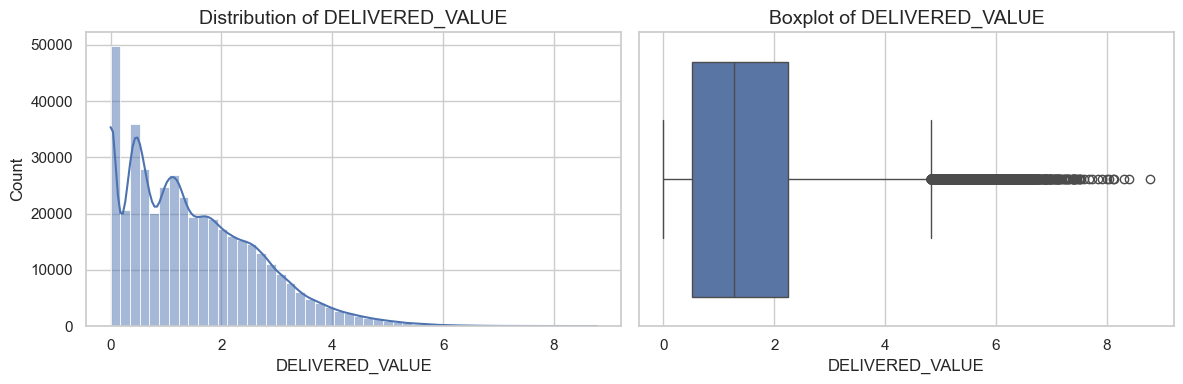

In [12]:
if sns is not None and delivered_col and delivered_col in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df[delivered_col].dropna(), bins=50, kde=True, ax=axes[0])
    axes[0].set_title(f"Distribution of {delivered_col}")
    axes[0].set_xlabel(delivered_col)
    sns.boxplot(x=df[delivered_col], ax=axes[1])
    axes[1].set_title(f"Boxplot of {delivered_col}")
    plt.tight_layout()
else:
    print("Install seaborn to render histograms/boxplots.")


In [13]:
power_zero_col = column_map.get("power_zero")
if power_zero_col and power_zero_col in df.columns:
    print(f"Analyzing {power_zero_col}")
    display(df[power_zero_col].describe())
    print(df[power_zero_col].value_counts(dropna=False))

    if delivered_col and delivered_col in df.columns:
        zero_deliveries = (df[delivered_col] == 0).sum()
        print(f"Zero delivered values: {zero_deliveries:,}")

energy_zero_col = column_map.get("daily_energy_zero")
energy_usage_col = column_map.get("daily_energy")
if energy_zero_col and energy_zero_col in df.columns:
    print(f"Analyzing {energy_zero_col}")
    display(df[energy_zero_col].describe())
    print(df[energy_zero_col].value_counts(dropna=False))

    if energy_usage_col and energy_usage_col in df.columns:
        zero_energy = (df[energy_usage_col] == 0).sum()
        print(f"Zero daily energy usage values: {zero_energy:,}")


Analyzing power_zero


count     422444
unique         2
top         True
freq      384353
Name: power_zero, dtype: object

power_zero
True     384353
False     38091
Name: count, dtype: int64
Zero delivered values: 38,091
Analyzing daily_energy_zero


count     422444
unique         2
top         True
freq      396164
Name: daily_energy_zero, dtype: object

daily_energy_zero
True     396164
False     26280
Name: count, dtype: int64
Zero daily energy usage values: 26,280


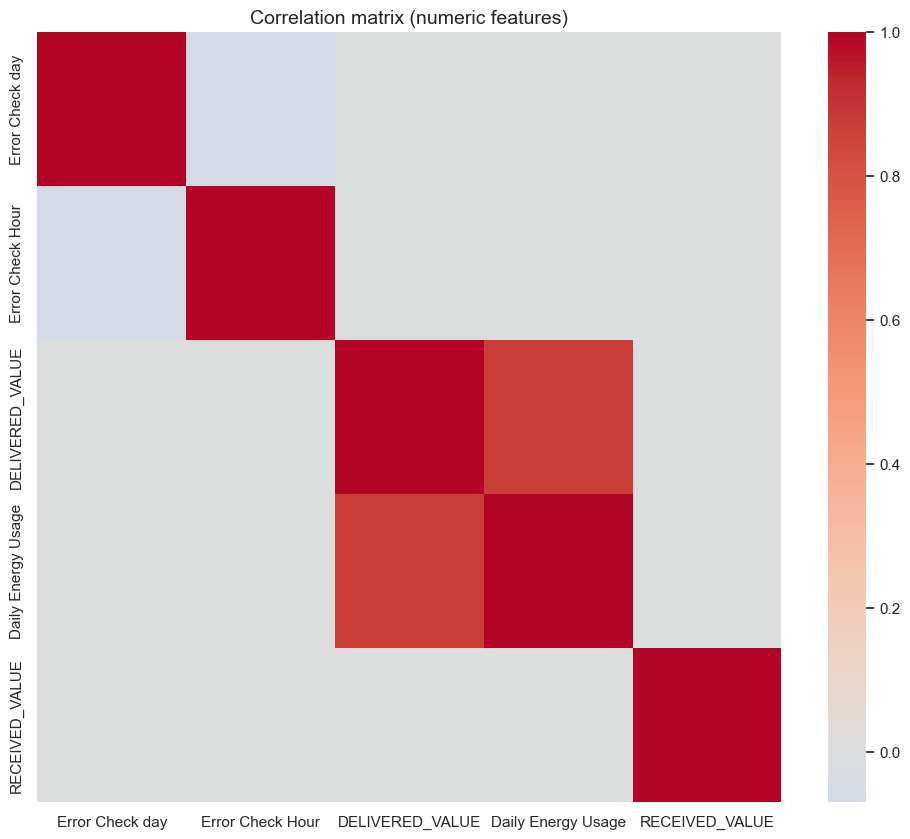

In [14]:
if delivered_col and delivered_col in df.columns:
    corr = df[numeric_columns].select_dtypes(include=[np.number]).corr()
    if sns is not None:
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
        plt.title("Correlation matrix (numeric features)")
        plt.show()
    else:
        print("Install seaborn to render correlation heatmap.")


## 3. Per-Meter Profiling (From `per_meter_eda.py`)


In [15]:
meter_col = column_map.get("meter")
nmi_col = column_map.get("nmi")

if meter_col and timestamp_col and delivered_col:
    meter_summary = compute_meter_summaries(
        df,
        meter_col=meter_col,
        timestamp_col=timestamp_col,
        delivered_col=delivered_col,
        daily_energy_col=column_map.get("daily_energy"),
        received_col=column_map.get("received"),
        nmi_col=nmi_col,
        power_zero_col=column_map.get("power_zero"),
        daily_energy_zero_col=column_map.get("daily_energy_zero"),
    )
    meter_summary = attach_peer_comparison(
        df,
        meter_summary,
        meter_col=meter_col,
        delivered_col=delivered_col,
        daily_energy_col=column_map.get("daily_energy"),
    )
    print("Per-meter summary (top rows)")
    display(meter_summary.head())
else:
    meter_summary = pd.DataFrame()
    print("Meter, timestamp, or delivered columns are missing; skipping per-meter summary.")


Per-meter summary (top rows)


,nmi_count,start_time,end_time,observation_count,delivered_mean,delivered_median,delivered_std,delivered_min,delivered_p25,delivered_p75,delivered_max,delivered_sum,daily_energy_mean,daily_energy_std,daily_energy_sum,received_mean,received_sum,period_hours,period_days,coverage_pct,delivered_cv,power_zero_pct,daily_energy_zero_pct,delivered_vs_peers_pct,delivered_mean_rank,delivered_sum_rank,daily_energy_vs_peers_pct
METER_UI,,,,,,,,,,,,,,,,,,,,,,,,,,,
M1,1,2022-04-25,2023-04-24,8760,2.1296,2.1620,1.2678,0.000,0.9557,2.9243,6.906,18655.4629,51.1109,21.2473,447731.1250,0.0,0.0,8737.0,364.0417,100.2632,0.5953,99.9315,100.0000,44.2063,10,10,44.2075
M10,1,2022-04-25,2023-04-24,8760,2.8869,3.0725,1.3048,0.000,2.0343,3.8090,8.311,25289.3086,69.2858,24.8957,606943.4375,0.0,0.0,8737.0,364.0417,100.2632,0.4520,98.0023,98.9041,97.6318,2,2,97.6335
M11,1,2022-04-25,2023-04-24,8760,2.4518,2.4980,1.1261,0.074,1.6158,3.0780,8.404,21477.5801,58.8427,22.1461,515461.9375,0.0,0.0,8737.0,364.0417,100.2632,0.4593,100.0000,100.0000,66.7917,6,6,66.7931
M12,1,2022-04-25,2023-04-24,8760,1.4192,1.4060,0.5997,0.000,1.0208,1.8270,4.840,12431.8193,34.0598,10.0822,298363.6562,0.0,0.0,8737.0,364.0417,100.2632,0.4226,99.9658,100.0000,-4.8714,24,24,-4.8706
M13,1,2022-04-25,2023-04-24,8760,2.3418,2.2630,1.1497,0.000,1.5067,3.0330,8.771,20514.5098,56.2041,18.8331,492348.2500,0.0,0.0,8737.0,364.0417,100.2632,0.4909,99.9658,100.0000,59.0607,8,8,59.0621


In [16]:
if not meter_summary.empty:
    print("Summary snapshot")
    display(
        meter_summary[
            [
                col
                for col in [
                    "observation_count",
                    "delivered_mean",
                    "delivered_vs_peers_pct",
                    "power_zero_pct",
                    "coverage_pct",
                ]
                if col in meter_summary.columns
            ]
        ]
        .sort_values(by="delivered_mean", ascending=False)
        .head(10)
    )
else:
    print("Meter summary is empty; nothing to display.")


Summary snapshot


,observation_count,delivered_mean,delivered_vs_peers_pct,power_zero_pct,coverage_pct
METER_UI,,,,,
M8,8760,3.0537,109.5599,99.9886,100.2632
M10,8760,2.8869,97.6318,98.0023,100.2632
M19,8760,2.8351,93.9385,99.9543,100.2632
M14,8760,2.8233,93.1011,99.2352,100.2632
M43,8760,2.5686,75.0304,84.9543,100.2632
M11,8760,2.4518,66.7917,100.0000,100.2632
M32,8760,2.4403,65.9852,99.6918,100.2632
M13,8760,2.3418,59.0607,99.9658,100.2632
M28,8760,2.1696,46.9944,98.9726,100.2632


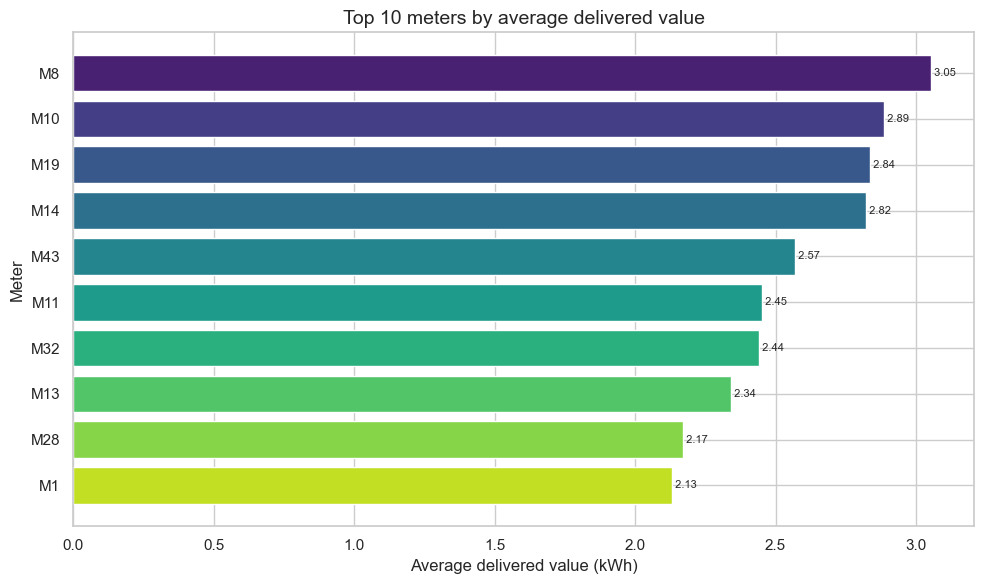

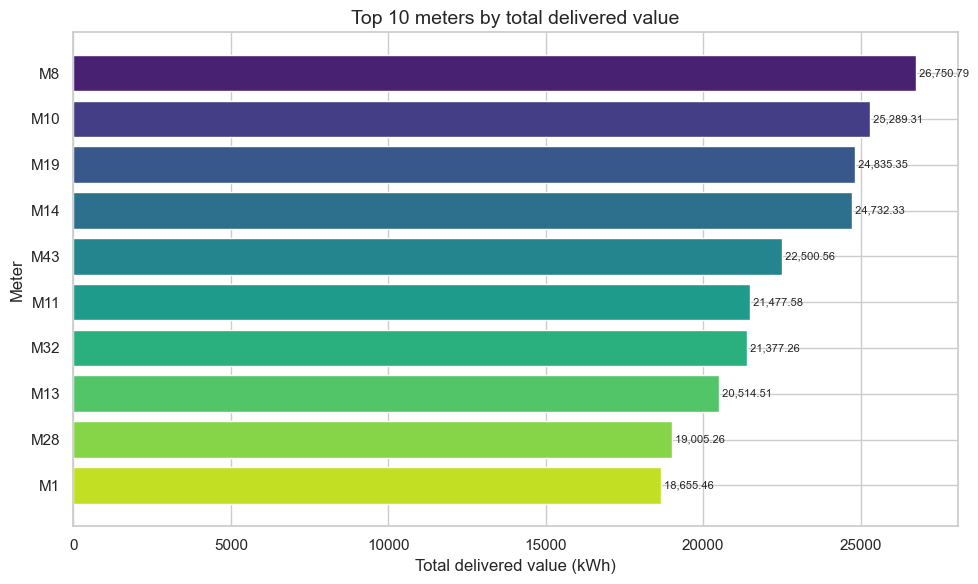

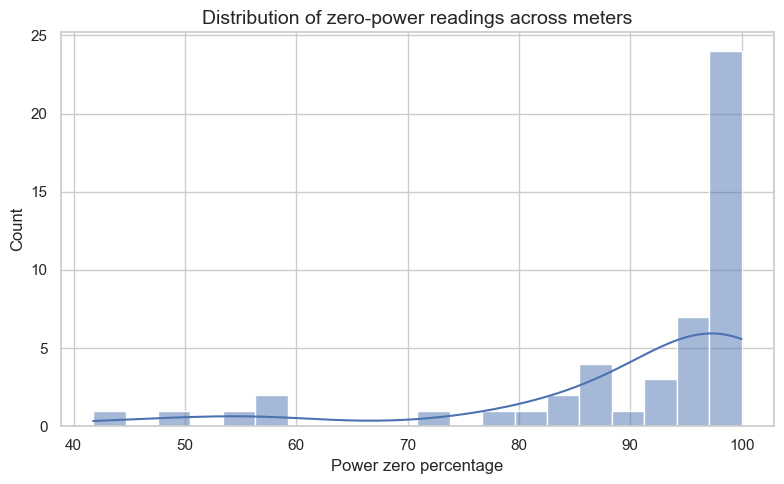

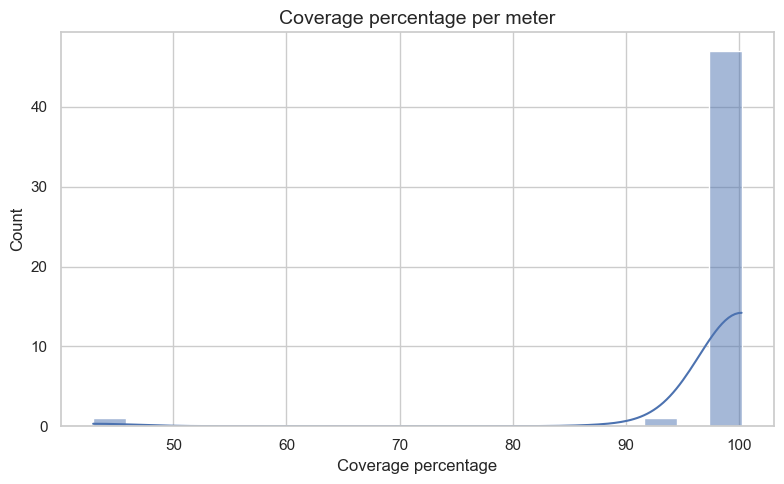

In [17]:
if not meter_summary.empty:
    _ = generate_summary_plots(meter_summary, show=True, top_n=10)
else:
    print("Meter summary is empty; skipping plots.")


## 4. Intra-Meter Weekly Diagnostics

This section extends the original scripts by examining how each meter behaves across weeks.


In [18]:
if meter_col and timestamp_col and value_columns:
    df_weekly = df[[meter_col, timestamp_col] + value_columns].copy()
    df_weekly[timestamp_col] = pd.to_datetime(df_weekly[timestamp_col], errors="coerce")
    df_weekly = df_weekly.dropna(subset=[timestamp_col])
    df_weekly["week_start"] = df_weekly[timestamp_col].dt.to_period("W").apply(lambda p: p.start_time)

    weekly_stats_list = []
    for value_col in value_columns:
        stats = (
            df_weekly.groupby([meter_col, "week_start"], observed=True)[value_col]
            .agg(
                count="count",
                mean="mean",
                median="median",
                std="std",
                min="min",
                q25=lambda x: x.quantile(0.25),
                q75=lambda x: x.quantile(0.75),
                max="max",
            )
            .reset_index()
        )
        stats["value_column"] = value_col
        weekly_stats_list.append(stats)

    weekly_stats = pd.concat(weekly_stats_list, ignore_index=True)
    print("Weekly distribution statistics (sample)")
    display(weekly_stats.head(20))
else:
    weekly_stats = pd.DataFrame()
    print("Cannot compute weekly diagnostics without meter, timestamp, and numeric value columns.")


Weekly distribution statistics (sample)


,METER_UI,week_start,count,mean,median,std,min,q25,q75,max,value_column
0,M1,2022-04-25,168,2.1320,2.1190,1.3335,0.392,0.9723,3.0430,5.869,DELIVERED_VALUE
1,M1,2022-05-02,168,2.6588,2.6850,0.8680,0.660,2.1445,3.2825,5.109,DELIVERED_VALUE
2,M1,2022-05-09,168,1.7338,1.4475,1.1993,0.318,0.7938,2.4205,6.671,DELIVERED_VALUE
3,M1,2022-05-16,168,1.7024,1.8335,1.1263,0.000,0.4723,2.5695,4.945,DELIVERED_VALUE
4,M1,2022-05-23,168,1.7997,1.8240,0.8850,0.448,0.8682,2.5525,3.639,DELIVERED_VALUE
5,M1,2022-05-30,168,1.7917,1.9560,0.8853,0.326,0.8863,2.5152,4.118,DELIVERED_VALUE
6,M1,2022-06-06,168,1.7408,1.5415,1.2009,0.304,0.5910,2.4500,6.342,DELIVERED_VALUE
7,M1,2022-06-13,168,0.9095,0.6095,0.6430,0.328,0.4632,1.1895,3.402,DELIVERED_VALUE
8,M1,2022-06-20,168,1.0887,0.8095,0.7711,0.329,0.5315,1.3680,4.282,DELIVERED_VALUE
9,M1,2022-06-27,168,0.8521,0.5910,0.6337,0.303,0.4492,0.9595,3.251,DELIVERED_VALUE


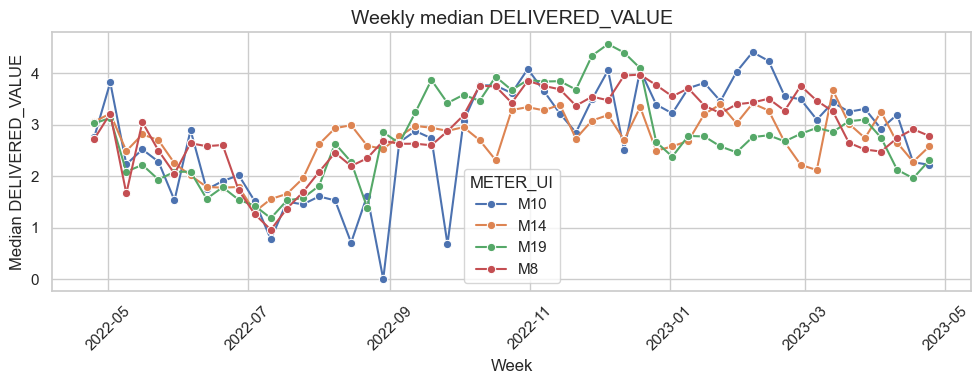

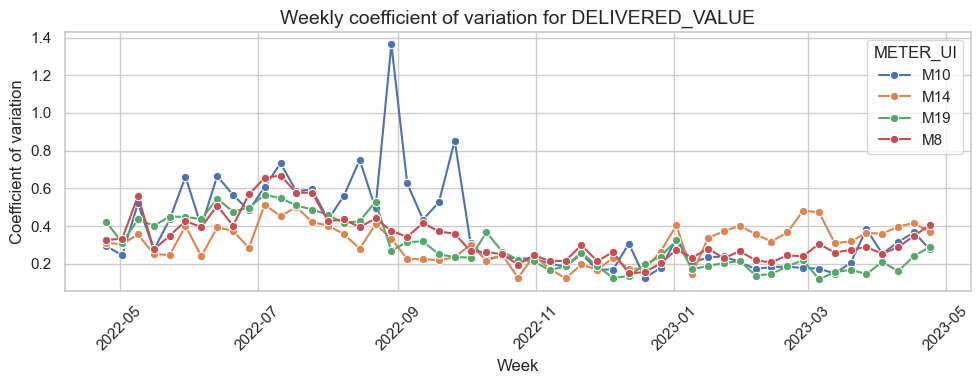

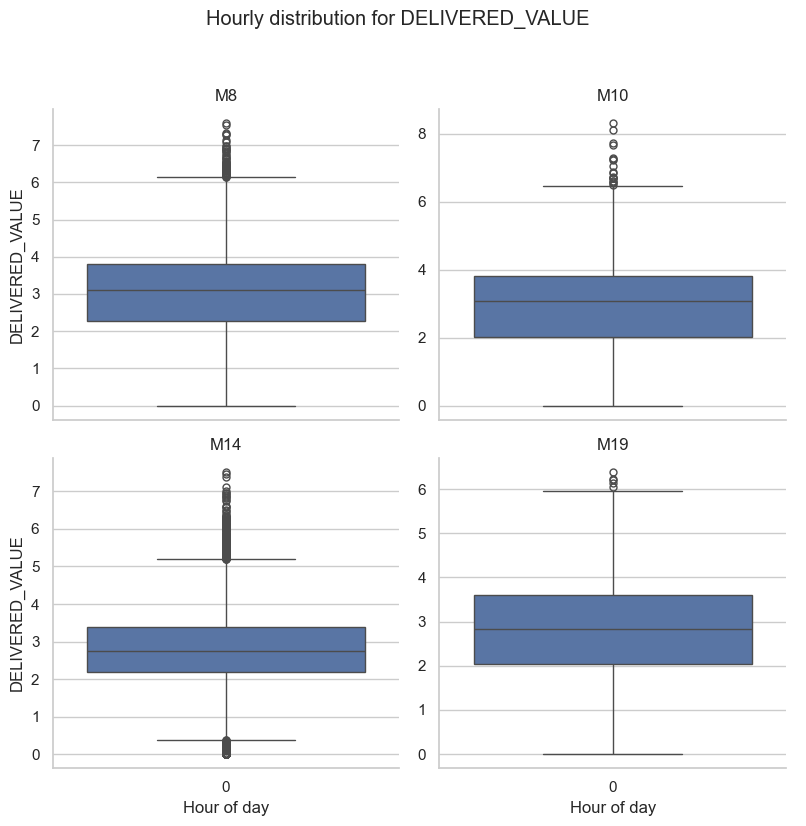

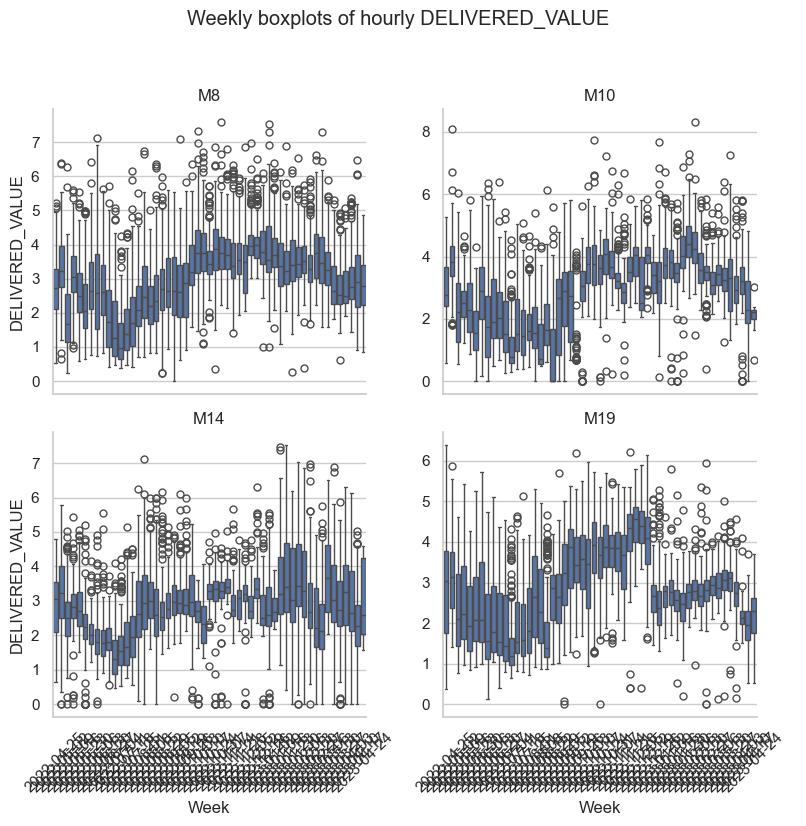

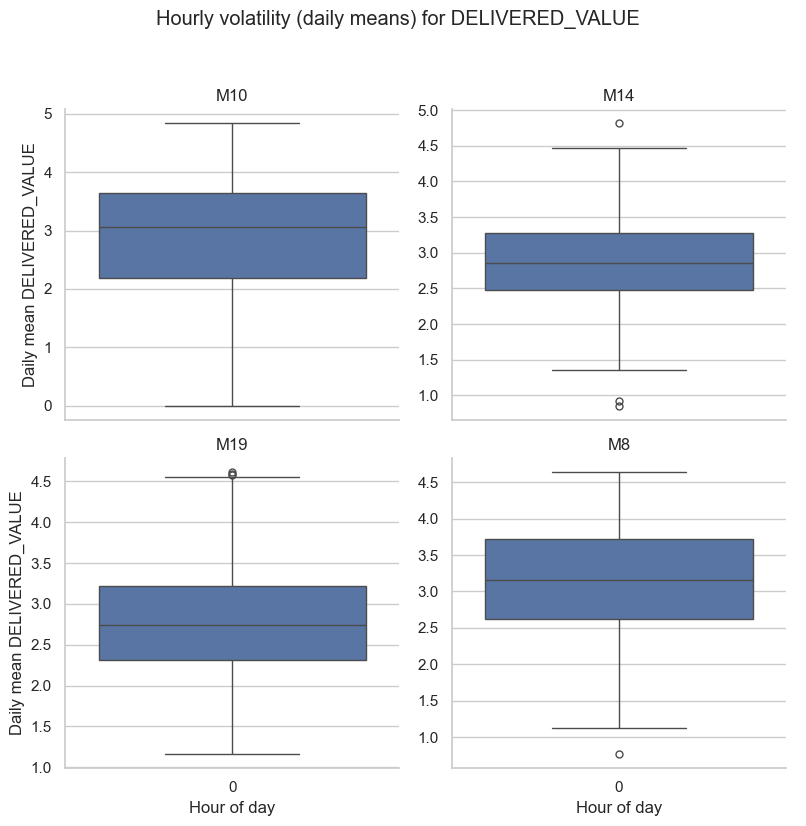

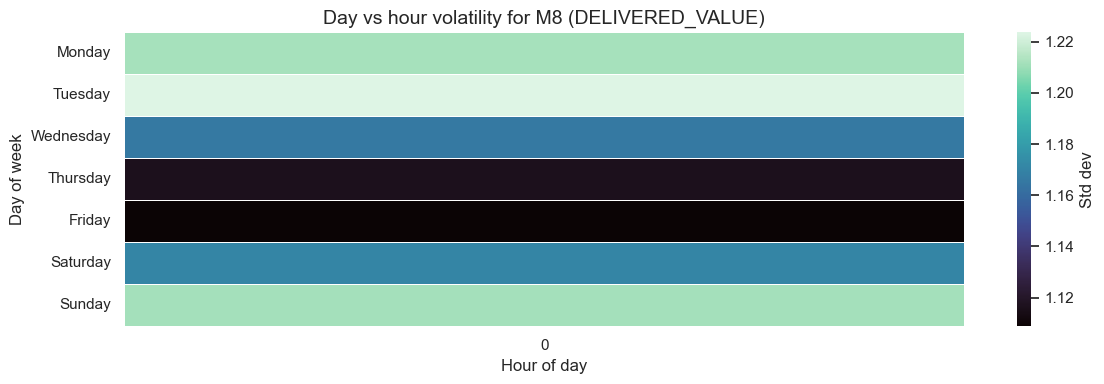

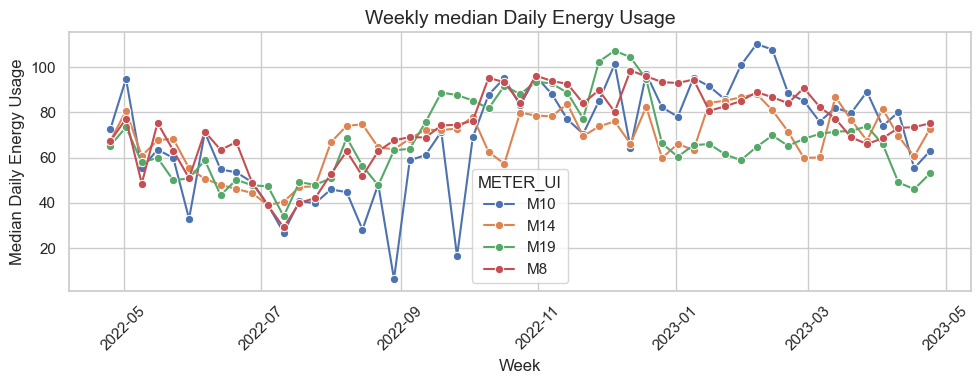

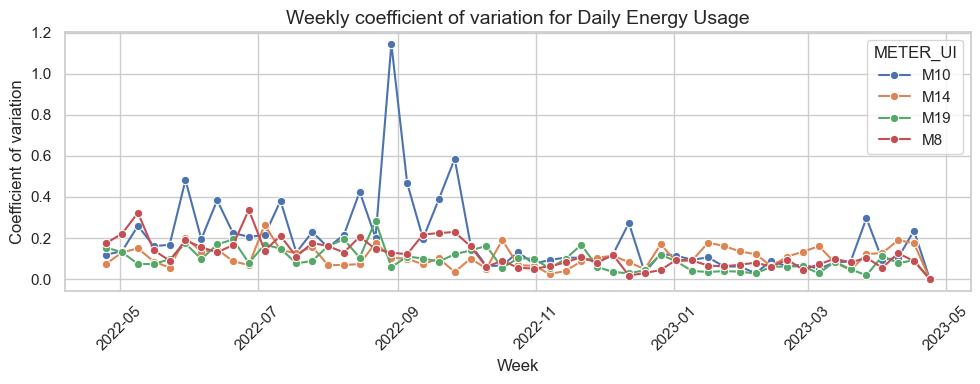

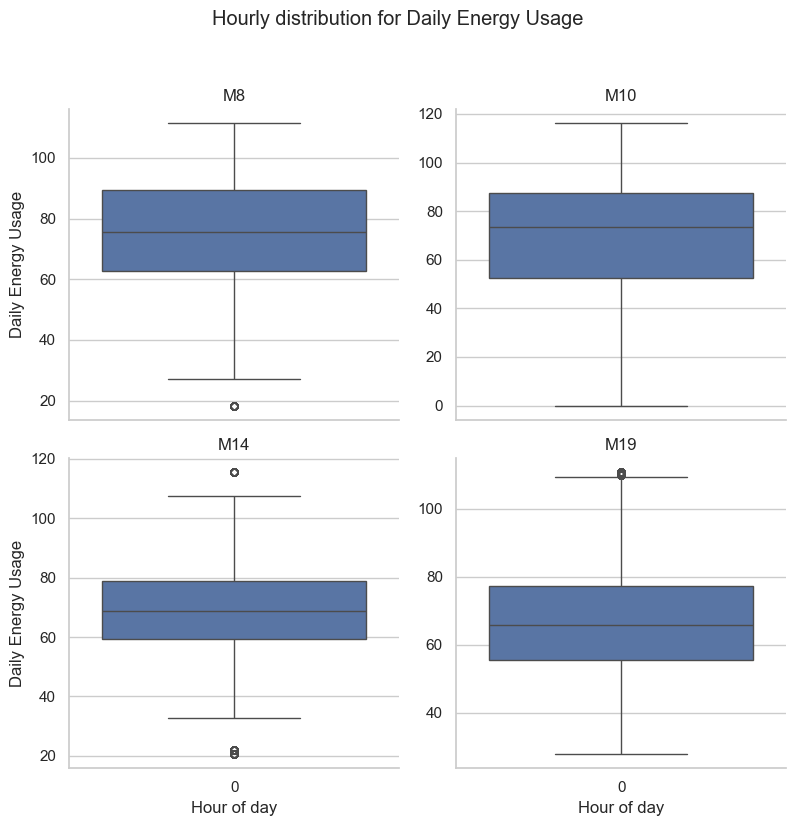

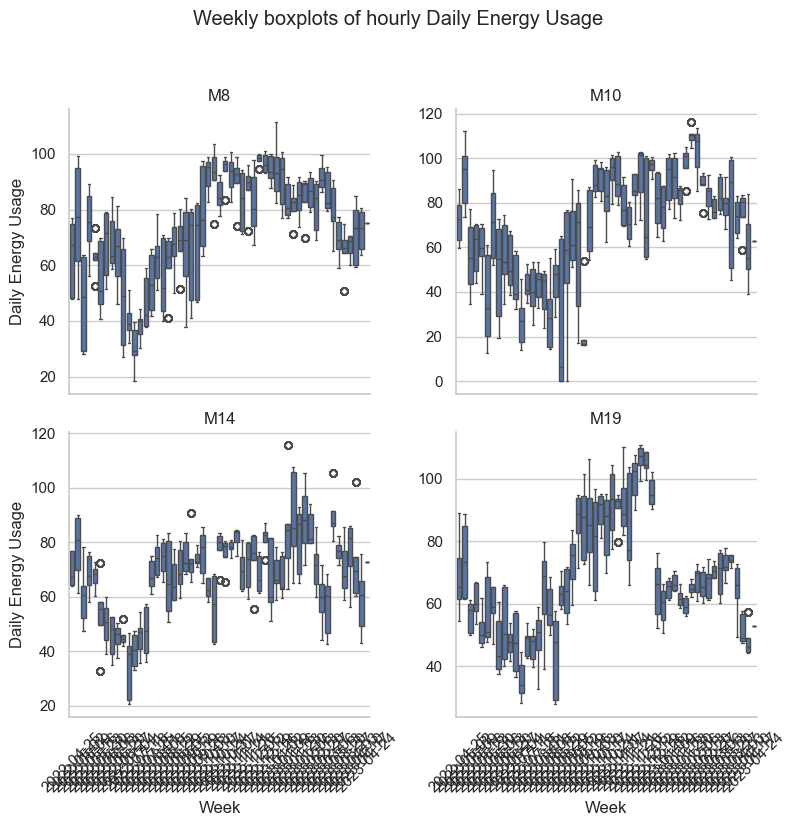

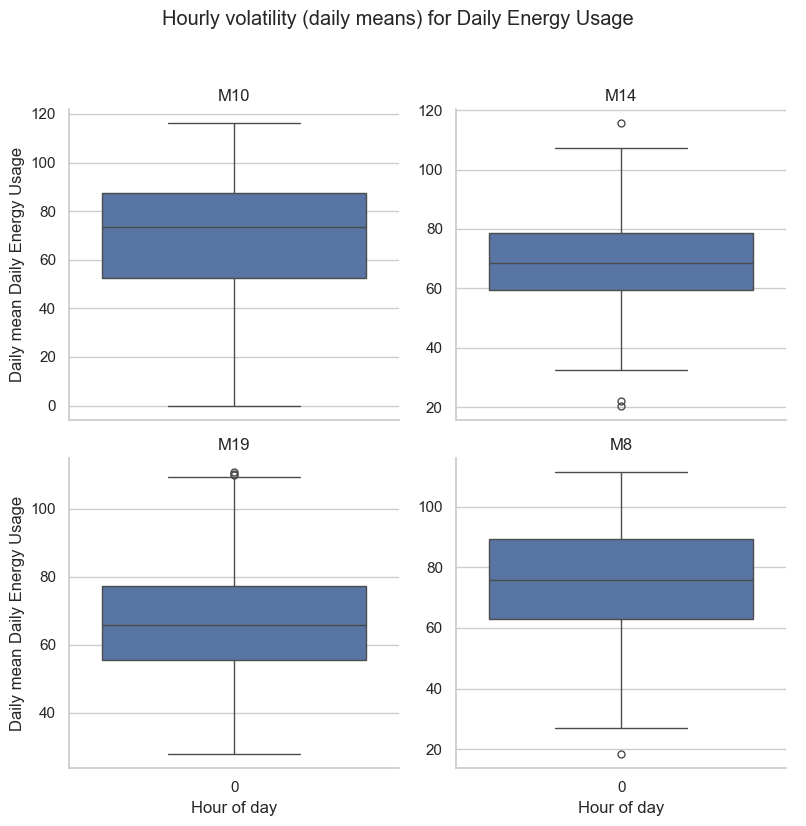

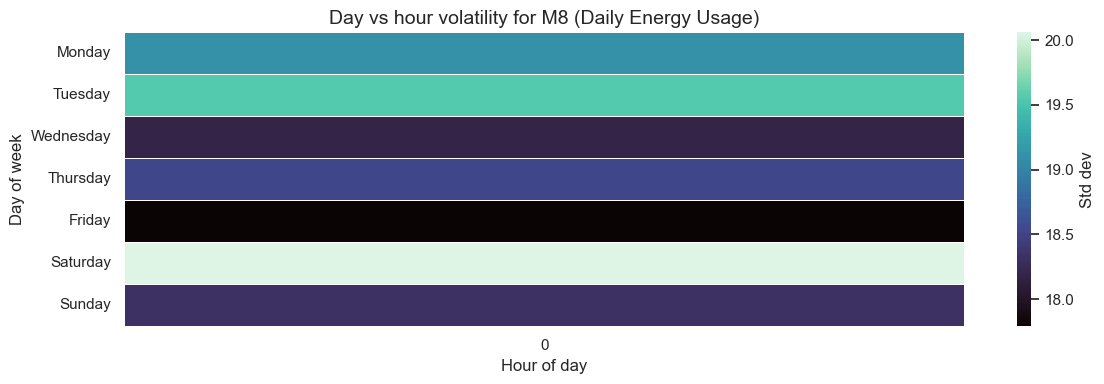

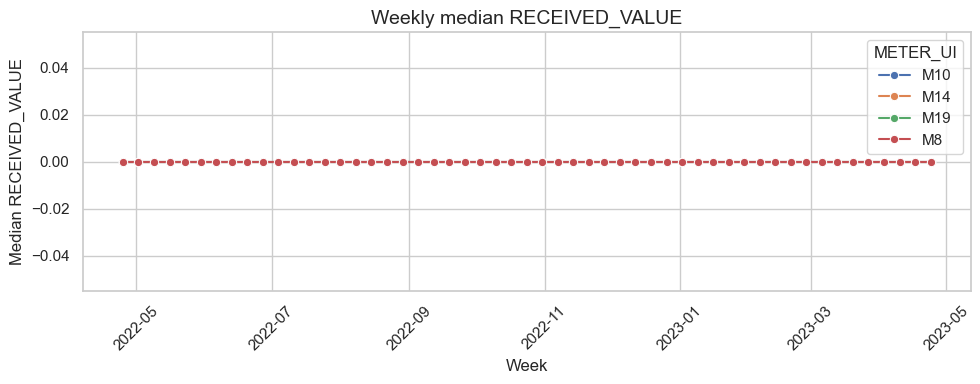

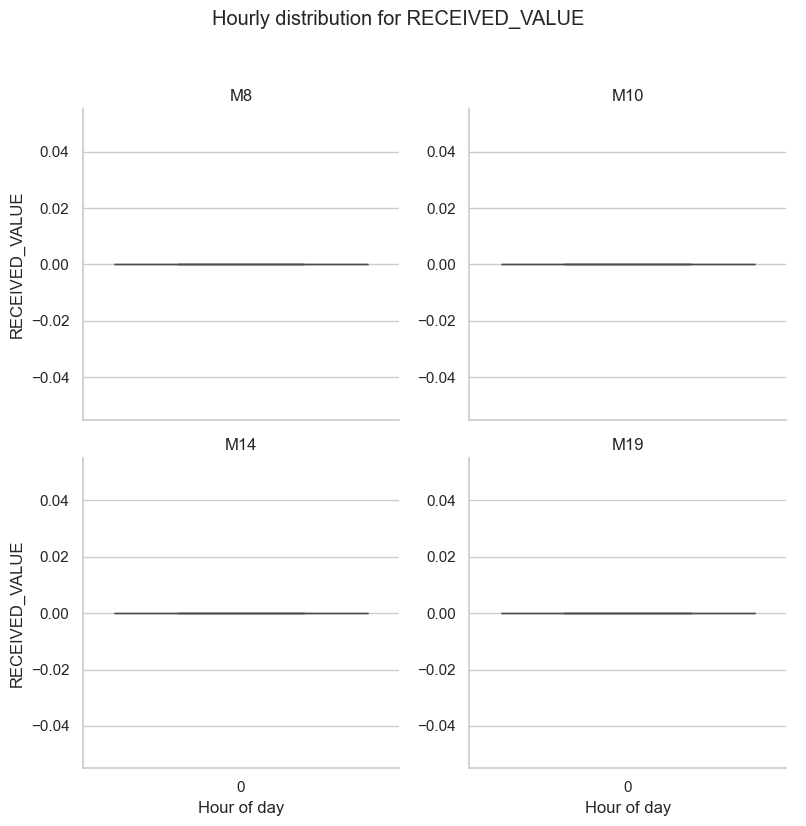

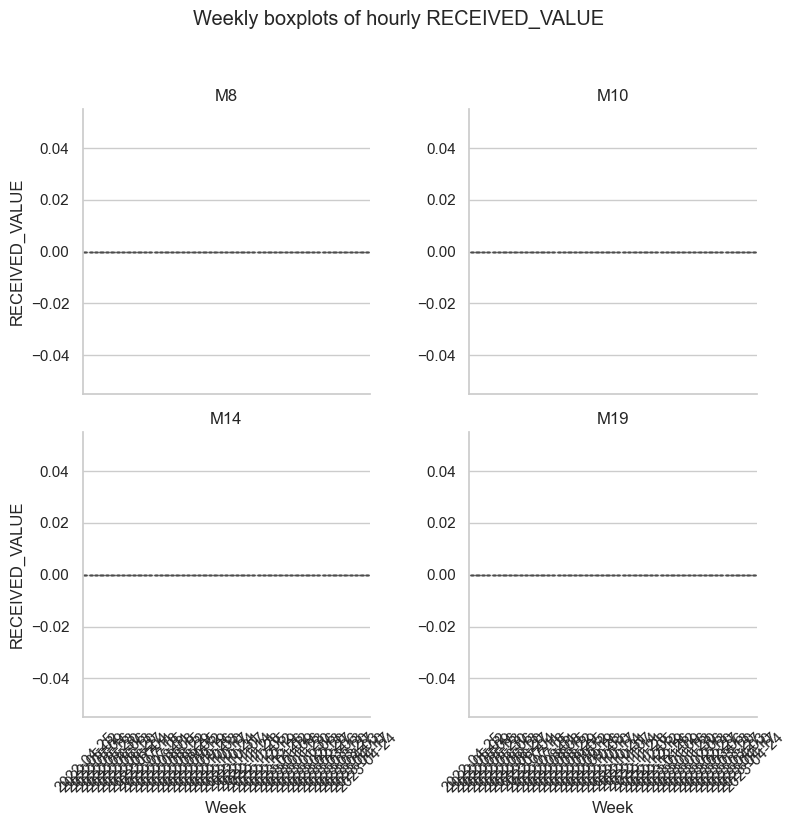

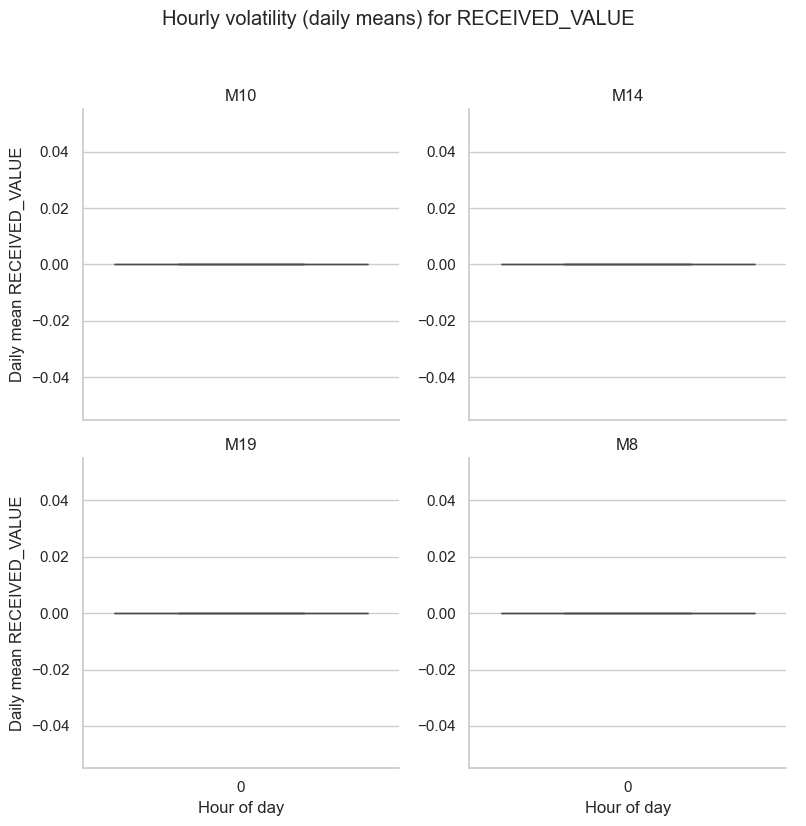

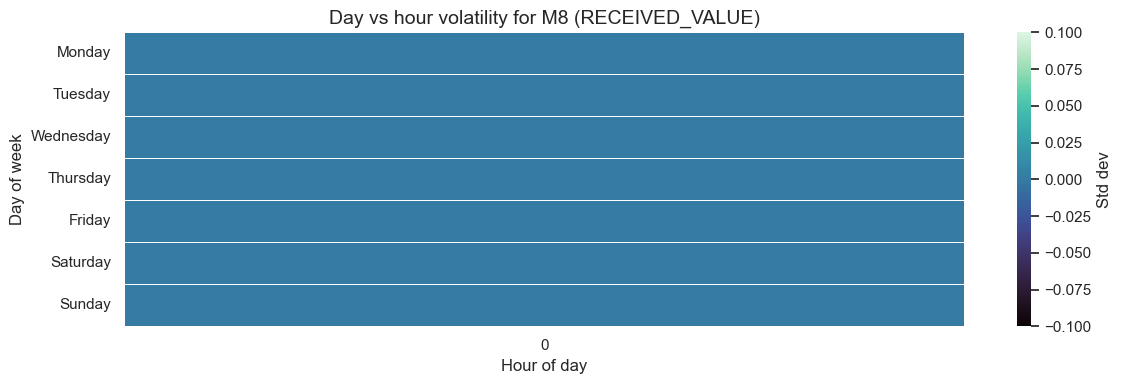

In [19]:

if sns is None:
    print("Install seaborn to render weekly diagnostics plots.")
elif weekly_stats.empty or meter_col is None or timestamp_col is None:
    if weekly_stats.empty:
        print("Weekly statistics not computed; skipping plots.")
    else:
        print("Meter or timestamp columns missing; cannot build weekly diagnostics.")
else:
    if not meter_summary.empty and "delivered_sum" in meter_summary.columns:
        top_meters = (
            meter_summary.sort_values("delivered_sum", ascending=False)
            .head(4)
            .index.astype(str)
        )
    elif meter_col in df.columns:
        top_meters = (
            df[meter_col]
            .astype(str)
            .value_counts()
            .head(4)
            .index
        )
    else:
        top_meters = []

    if len(top_meters) == 0:
        print("No meters available to plot.")
    else:
        selected_meters = [str(m) for m in top_meters]

        meter_subset = weekly_stats.copy()
        meter_subset[meter_col] = meter_subset[meter_col].astype(str)
        meter_subset = meter_subset[meter_subset[meter_col].isin(selected_meters)]
        meter_subset["week_start"] = pd.to_datetime(meter_subset["week_start"], errors="coerce")
        meter_subset = meter_subset.dropna(subset=["week_start"])
        meter_subset["week_label"] = meter_subset["week_start"].dt.strftime("%Y-%m-%d")
        if {"mean", "std"}.issubset(meter_subset.columns):
            meter_subset["cv"] = (meter_subset["std"] / meter_subset["mean"]).replace([np.inf, -np.inf], np.nan)
        else:
            meter_subset["cv"] = np.nan

        df_hourly = df[[meter_col, timestamp_col] + value_columns].copy()
        df_hourly = df_hourly[df_hourly[meter_col].astype(str).isin(selected_meters)]
        df_hourly[timestamp_col] = pd.to_datetime(df_hourly[timestamp_col], errors="coerce")
        df_hourly = df_hourly.dropna(subset=[timestamp_col])
        if df_hourly.empty:
            print("No timestamped records available after filtering; skipping hourly diagnostics.")
        else:
            df_hourly[meter_col] = df_hourly[meter_col].astype(str)
            df_hourly["hour"] = df_hourly[timestamp_col].dt.hour
            df_hourly["week_start"] = df_hourly[timestamp_col].dt.to_period("W").apply(lambda p: p.start_time)
            df_hourly["week_label"] = df_hourly["week_start"].dt.strftime("%Y-%m-%d")
            df_hourly["day"] = df_hourly[timestamp_col].dt.date
            df_hourly["day_of_week"] = df_hourly[timestamp_col].dt.day_name()
            hour_order = sorted(df_hourly["hour"].unique())
            week_order = sorted(df_hourly["week_label"].unique())

            daily_hour = (
                df_hourly.groupby([meter_col, "day", "hour"], observed=True)[value_columns]
                .mean()
                .reset_index()
            ) if value_columns else pd.DataFrame()
            if not daily_hour.empty:
                daily_hour[meter_col] = daily_hour[meter_col].astype(str)

            for value_col in value_columns:
                if value_col not in df_hourly.columns:
                    continue

                weekly_data = meter_subset[meter_subset["value_column"] == value_col].copy()
                weekly_data = weekly_data.sort_values([meter_col, "week_start"])

                if not weekly_data.empty:
                    plt.figure(figsize=(10, 4))
                    sns.lineplot(
                        data=weekly_data,
                        x="week_start",
                        y="median",
                        hue=meter_col,
                        marker="o",
                    )
                    plt.title(f"Weekly median {value_col}")
                    plt.xlabel("Week")
                    plt.ylabel(f"Median {value_col}")
                    plt.xticks(rotation=45)
                    plt.tight_layout()
                    plt.show()

                    if weekly_data["cv"].notna().any():
                        plt.figure(figsize=(10, 4))
                        sns.lineplot(
                            data=weekly_data.dropna(subset=["cv"]),
                            x="week_start",
                            y="cv",
                            hue=meter_col,
                            marker="o",
                        )
                        plt.title(f"Weekly coefficient of variation for {value_col}")
                        plt.xlabel("Week")
                        plt.ylabel("Coefficient of variation")
                        plt.xticks(rotation=45)
                        plt.tight_layout()
                        plt.show()

                hourly_box = sns.catplot(
                    data=df_hourly[[meter_col, "hour", value_col]].dropna(),
                    x="hour",
                    y=value_col,
                    col=meter_col,
                    kind="box",
                    col_wrap=2,
                    sharey=False,
                    height=4,
                    order=hour_order,
                )
                hourly_box.set_titles("{col_name}")
                hourly_box.set_axis_labels("Hour of day", value_col)
                hourly_box.fig.suptitle(f"Hourly distribution for {value_col}", y=1.03)
                hourly_box.fig.tight_layout()
                plt.show()

                weekly_box = sns.catplot(
                    data=df_hourly[[meter_col, "week_label", value_col]].dropna(),
                    x="week_label",
                    y=value_col,
                    col=meter_col,
                    kind="box",
                    col_wrap=2,
                    sharey=False,
                    height=4,
                    order=week_order,
                )
                weekly_box.set_titles("{col_name}")
                weekly_box.set_axis_labels("Week", value_col)
                for ax in weekly_box.axes.flatten():
                    ax.tick_params(axis="x", rotation=45)
                weekly_box.fig.suptitle(f"Weekly boxplots of hourly {value_col}", y=1.03)
                weekly_box.fig.tight_layout()
                plt.show()

                if not daily_hour.empty and value_col in daily_hour.columns:
                    volatility_box = sns.catplot(
                        data=daily_hour[[meter_col, "hour", value_col]].dropna(),
                        x="hour",
                        y=value_col,
                        col=meter_col,
                        kind="box",
                        col_wrap=2,
                        sharey=False,
                        height=4,
                        order=hour_order,
                    )
                    volatility_box.set_titles("{col_name}")
                    volatility_box.set_axis_labels("Hour of day", f"Daily mean {value_col}")
                    volatility_box.fig.suptitle(f"Hourly volatility (daily means) for {value_col}", y=1.03)
                    volatility_box.fig.tight_layout()
                    plt.show()

                focus_meter = selected_meters[0]
                focus_subset = df_hourly[df_hourly[meter_col] == focus_meter]
                if not focus_subset.empty:
                    heatmap_data = (
                        focus_subset.groupby(["day_of_week", "hour"])[value_col]
                        .std()
                        .unstack(fill_value=np.nan)
                        .reindex(
                            [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ]
                        )
                    )
                    plt.figure(figsize=(12, 4))
                    sns.heatmap(
                        heatmap_data,
                        cmap="mako",
                        linewidths=0.5,
                        linecolor="white",
                        cbar_kws={"label": "Std dev"},
                    )
                    plt.title(f"Day vs hour volatility for {focus_meter} ({value_col})")
                    plt.xlabel("Hour of day")
                    plt.ylabel("Day of week")
                    plt.tight_layout()
                    plt.show()






## 5. Community-Level Usage Profiles

Community-wide view comparing weekday vs weekend daily usage and monthly hourly patterns.


Average daily energy usage (community-wide):


,day_type,avg_daily_usage
0,Weekday,35.5772
1,Weekend,36.5689


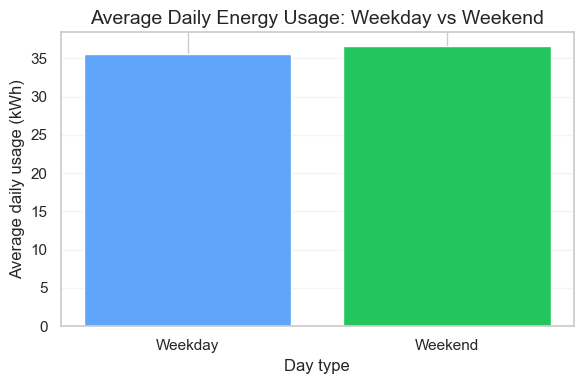

Average hourly usage per month (community-wide):


,month,hour,avg_hourly_usage
0,2022-04,0,33.9110
1,2022-05,0,32.7854
2,2022-06,0,26.7199
3,2022-07,0,20.4676
4,2022-08,0,26.6617
5,2022-09,0,34.5517
6,2022-10,0,41.0670
7,2022-11,0,40.4977
8,2022-12,0,44.6774
9,2023-01,0,40.4976


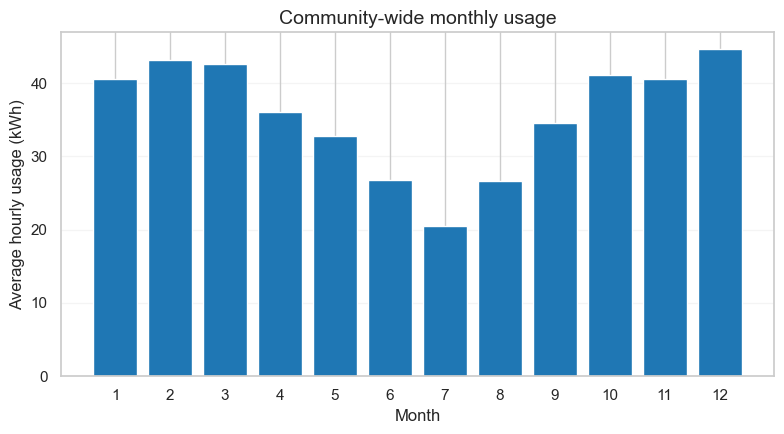

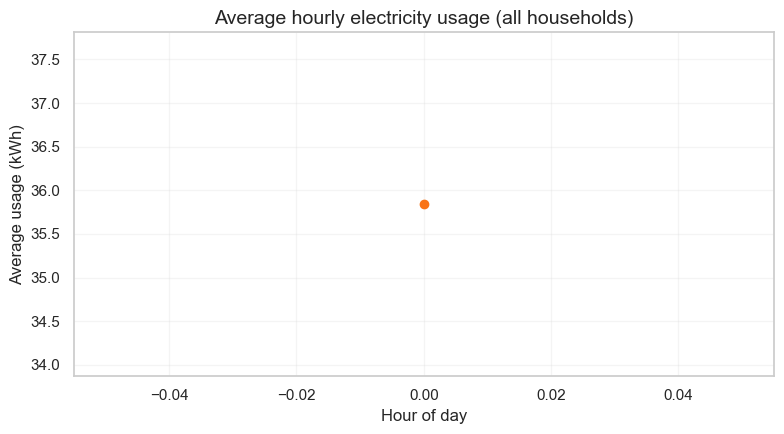

In [20]:

community_value_col = column_map.get("daily_energy") or column_map.get("delivered")

if timestamp_col is None:
    print("Timestamp column not identified; cannot compute community usage profiles.")
elif community_value_col is None or community_value_col not in df.columns:
    print("No usable energy column (`daily_energy` or `delivered`) found; cannot compute community usage profiles.")
else:
    usage = df[[timestamp_col, community_value_col]].copy()
    usage[timestamp_col] = pd.to_datetime(usage[timestamp_col], errors="coerce")
    usage = usage.dropna(subset=[timestamp_col, community_value_col])

    if usage.empty:
        print("No usable timestamped records after cleaning; cannot compute community usage profiles.")
    else:
        usage["day"] = usage[timestamp_col].dt.date
        usage["is_weekend"] = usage[timestamp_col].dt.dayofweek >= 5
        usage["month"] = usage[timestamp_col].dt.to_period("M")
        usage["hour"] = usage[timestamp_col].dt.hour

        daily_profile = (
            usage.groupby(["is_weekend", "day"], observed=True)[community_value_col]
            .mean()
            .reset_index()
        )
        weekday_vs_weekend = (
            daily_profile.groupby("is_weekend", observed=True)[community_value_col]
            .mean()
            .reset_index()
            .rename(columns={community_value_col: "avg_daily_usage"})
        )
        weekday_vs_weekend["day_type"] = weekday_vs_weekend["is_weekend"].map({False: "Weekday", True: "Weekend"})
        weekday_vs_weekend = weekday_vs_weekend[["day_type", "avg_daily_usage"]]
        print("Average daily energy usage (community-wide):")
        display(weekday_vs_weekend)

        if not weekday_vs_weekend.empty:
            weekday_plot = weekday_vs_weekend.copy()
            weekday_plot["day_type"] = pd.Categorical(
                weekday_plot["day_type"], categories=["Weekday", "Weekend"], ordered=True
            )
            weekday_plot = weekday_plot.sort_values("day_type")
            fig, ax = plt.subplots(figsize=(6, 4), facecolor="white")
            colors = ["#60a5fa", "#22c55e"]
            ax.bar(
                weekday_plot["day_type"],
                weekday_plot["avg_daily_usage"],
                color=colors[: len(weekday_plot)],
            )
            ax.set_facecolor("white")
            ax.grid(axis="y", alpha=0.2)
            ax.set_ylabel("Average daily usage (kWh)")
            ax.set_xlabel("Day type")
            ax.set_title("Average Daily Energy Usage: Weekday vs Weekend")
            plt.tight_layout()
            plt.show()

        hourly_monthly = (
            usage.groupby(["month", "hour"], observed=True)[community_value_col]
            .mean()
            .reset_index()
            .rename(columns={community_value_col: "avg_hourly_usage"})
        )
        hourly_monthly["month"] = hourly_monthly["month"].astype(str)
        print("Average hourly usage per month (community-wide):")
        display(hourly_monthly.head(48))

        if not hourly_monthly.empty:
            period_index = pd.PeriodIndex(hourly_monthly["month"], freq="M", name="month")
            monthly_bar = (
                pd.DataFrame({
                    "month_num": period_index.month,
                    "avg_hourly_usage": hourly_monthly["avg_hourly_usage"].values,
                })
                .groupby("month_num", sort=True)["avg_hourly_usage"]
                .mean()
                .dropna()
            )
            if monthly_bar.empty:
                print("Not enough month-level data to plot community usage.")
            else:
                fig, ax = plt.subplots(figsize=(8, 4.5), facecolor="white")
                ax.bar(monthly_bar.index.astype(str), monthly_bar.values, color="#1f77b4")
                ax.set_facecolor("white")
                ax.grid(axis="y", alpha=0.2)
                ax.set_xlabel("Month")
                ax.set_ylabel("Average hourly usage (kWh)")
                ax.set_title("Community-wide monthly usage")
                plt.tight_layout()
                plt.show()
        else:
            print("No hourly records available to build the community usage chart.")

        hourly_profile = (
            usage.groupby("hour", observed=True)[community_value_col]
            .mean()
            .reset_index()
            .rename(columns={community_value_col: "avg_hourly_usage"})
            .sort_values("hour")
        )
        if not hourly_profile.empty:
            fig, ax = plt.subplots(figsize=(8, 4.5), facecolor="white")
            ax.plot(
                hourly_profile["hour"],
                hourly_profile["avg_hourly_usage"],
                color="#f97316",
                marker="o",
                linewidth=2,
            )
            ax.set_facecolor("white")
            ax.grid(alpha=0.2)
            ax.set_xlabel("Hour of day")
            ax.set_ylabel("Average usage (kWh)")
            ax.set_title("Average hourly electricity usage (all households)")
            plt.tight_layout()
            plt.show()
        else:
            print("No hourly records available to build the hourly profile chart.")


## 6. Household Usage Clusters

Cluster households based on average daily usage (x-axis) and daily volatility (y-axis).


,METER_UI,avg_daily_usage,std_daily_usage,days_observed,cluster_label
47,M8,1756.2760,456.0404,365,High usage + high volatility
1,M10,1660.6166,600.3828,365,High usage + high volatility
10,M19,1633.0093,438.5534,365,High usage + high volatility
5,M14,1626.2352,360.2425,365,High usage + high volatility
37,M43,1479.1500,774.2911,365,High usage + high volatility
2,M11,1410.4006,534.5329,365,High usage + high volatility
25,M32,1405.6283,603.5051,365,High usage + high volatility
4,M13,1348.8993,452.5902,365,High usage + high volatility
20,M28,1249.6610,426.4881,365,High usage + high volatility
0,M1,1225.2725,512.2673,365,High usage + high volatility


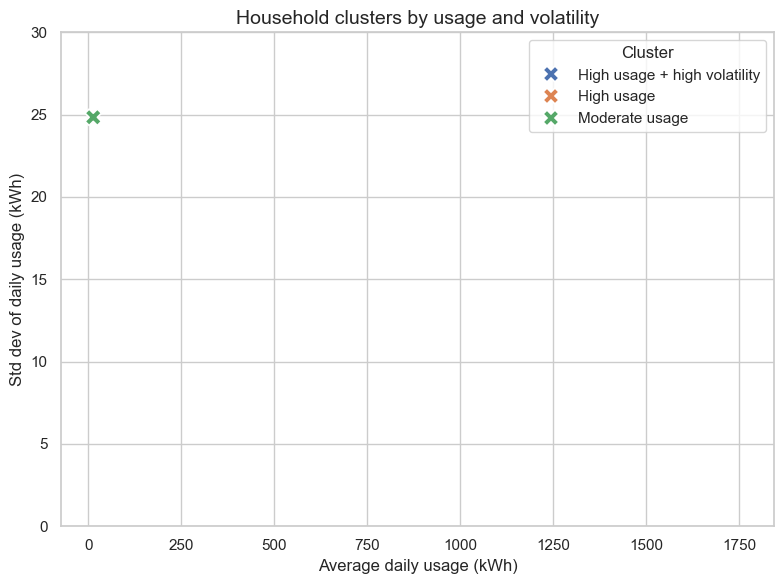

In [21]:

try:
    from sklearn.cluster import KMeans
except ImportError:
    KMeans = None

cluster_value_col = column_map.get("daily_energy") or column_map.get("delivered")
meter_identifier = column_map.get("meter")

if KMeans is None:
    print("Install scikit-learn to build household clusters (e.g., `pip install scikit-learn`).")
elif meter_identifier is None or timestamp_col is None:
    print("Meter or timestamp column missing; cannot build household clusters.")
elif cluster_value_col is None or cluster_value_col not in df.columns:
    print("No usable energy column (`daily_energy` or `delivered`) found; cannot build household clusters.")
else:
    usage = df[[meter_identifier, timestamp_col, cluster_value_col]].copy()
    usage[timestamp_col] = pd.to_datetime(usage[timestamp_col], errors="coerce")
    usage = usage.dropna(subset=[meter_identifier, timestamp_col, cluster_value_col])
    usage[meter_identifier] = usage[meter_identifier].astype(str)

    if usage.empty:
        print("No usable records after cleaning; cannot build household clusters.")
    else:
        usage["day"] = usage[timestamp_col].dt.date
        daily_totals = (
            usage.groupby([meter_identifier, "day"], observed=True)[cluster_value_col]
            .sum()
            .reset_index()
            .rename(columns={cluster_value_col: "daily_usage"})
        )

        if daily_totals.empty:
            print("Daily aggregation produced no rows; cannot build household clusters.")
        else:
            per_meter = (
                daily_totals.groupby(meter_identifier, observed=True)["daily_usage"]
                .agg(
                    avg_daily_usage="mean",
                    std_daily_usage="std",
                    days_observed="count",
                )
                .reset_index()
            )
            per_meter["std_daily_usage"] = per_meter["std_daily_usage"].fillna(0.0)
            per_meter = per_meter.dropna(subset=["avg_daily_usage"])

            if len(per_meter) < 3:
                print("Need at least three households to form clusters; found only", len(per_meter))
            else:
                features = per_meter[["avg_daily_usage", "std_daily_usage"]].to_numpy()
                model = KMeans(n_clusters=3, random_state=42, n_init=25)
                labels = model.fit_predict(features)
                per_meter["cluster_id"] = labels

                centers = model.cluster_centers_
                order = sorted(range(3), key=lambda idx: centers[idx][0])
                moderate_idx = order[0]
                high_low_vol_idx, high_high_vol_idx = order[1], order[2]
                if centers[high_low_vol_idx][1] < centers[high_high_vol_idx][1]:
                    high_idx = high_low_vol_idx
                    high_vol_idx = high_high_vol_idx
                else:
                    high_idx = high_high_vol_idx
                    high_vol_idx = high_low_vol_idx

                cluster_names = {
                    moderate_idx: "Moderate usage",
                    high_idx: "High usage",
                    high_vol_idx: "High usage + high volatility",
                }
                per_meter["cluster_label"] = per_meter["cluster_id"].map(cluster_names)

                display(
                    per_meter[[meter_identifier, "avg_daily_usage", "std_daily_usage", "days_observed", "cluster_label"]]
                    .sort_values(by="avg_daily_usage", ascending=False)
                    .head(20)
                )

                if sns is not None:
                    plt.figure(figsize=(8, 6))
                    sns.scatterplot(
                        data=per_meter,
                        x="avg_daily_usage",
                        y="std_daily_usage",
                        hue="cluster_label",
                        marker="X",
                        s=140,
                        linewidth=1.2,
                    )
                else:
                    plt.figure(figsize=(8, 6))
                    unique_clusters = per_meter["cluster_label"].unique()
                    colors = plt.cm.tab10.colors
                    for idx, label in enumerate(unique_clusters):
                        subset = per_meter[per_meter["cluster_label"] == label]
                        plt.scatter(
                            subset["avg_daily_usage"],
                            subset["std_daily_usage"],
                            label=label,
                            marker="x",
                            linewidths=1.2,
                            color=colors[idx % len(colors)],
                            s=140,
                        )
                plt.xlabel("Average daily usage (kWh)")
                plt.ylabel("Std dev of daily usage (kWh)")
                plt.ylim(0, 30)
                plt.title("Household clusters by usage and volatility")
                plt.legend(title="Cluster")
                plt.tight_layout()
                plt.show()


## 7. Top Household Usage vs National Average

Identify the highest-consuming meters (based on `delivered_value`) and compare them to the 9,019 kWh national average.


Top 5 meters by total delivered energy:


,METER_UI,total_delivered_kwh
0,M8,26750.7949
1,M10,25289.3086
2,M19,24835.3496
3,M14,24732.3262
4,M43,22500.5586


C:\Users\Owner\AppData\Local\Temp\ipykernel_10116\3327328122.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")


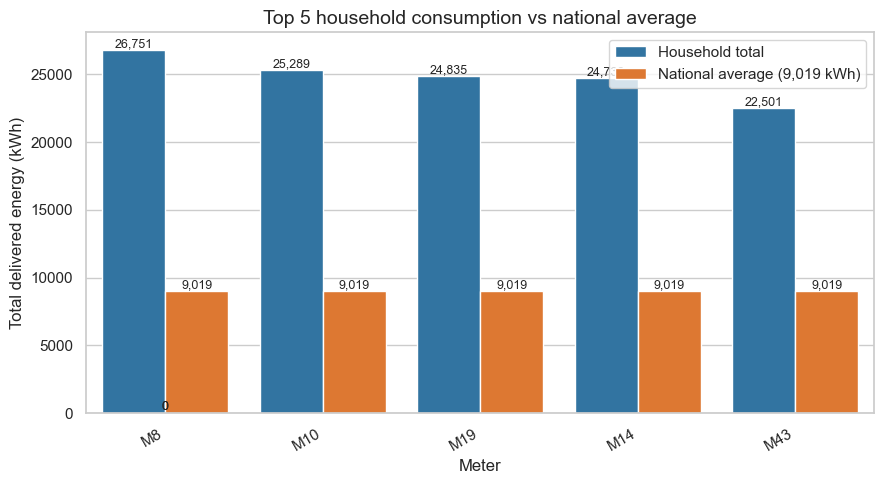

In [22]:

national_avg_kwh = 9019.0
meter_identifier = column_map.get("meter")
delivered_col = column_map.get("delivered")

if meter_identifier is None:
    print("Meter column not detected; cannot build top-household chart.")
elif delivered_col is None or delivered_col not in df.columns:
    print("`delivered_value` column missing; cannot compute consumption totals.")
else:
    totals = (
        df[[meter_identifier, delivered_col]]
        .dropna(subset=[meter_identifier, delivered_col])
        .groupby(meter_identifier, observed=True)[delivered_col]
        .sum()
        .rename("total_delivered_kwh")
        .sort_values(ascending=False)
    )

    if totals.empty:
        print("No delivered values available to compute totals.")
    else:
        top5 = totals.head(5).reset_index()
        top5[meter_identifier] = top5[meter_identifier].astype(str)
        print("Top 5 meters by total delivered energy:")
        display(top5)

        comparison = pd.concat(
            [
                top5.assign(series="Household total"),
                top5[[meter_identifier]].assign(
                    total_delivered_kwh=national_avg_kwh,
                    series="National average (9,019 kWh)",
                ),
            ],
            ignore_index=True,
        )
        comparison["series"] = pd.Categorical(
            comparison["series"],
            categories=["Household total", "National average (9,019 kWh)"],
            ordered=True,
        )

        plt.figure(figsize=(9, 5))
        if sns is not None:
            ax = sns.barplot(
                data=comparison,
                x=meter_identifier,
                y="total_delivered_kwh",
                hue="series",
                palette=["#1f77b4", "#f97316"],
            )
        else:
            meters = top5[meter_identifier]
            x = np.arange(len(meters))
            width = 0.4
            ax = plt.gca()
            ax.bar(
                x - width / 2,
                top5["total_delivered_kwh"],
                width,
                label="Household total",
                color="#1f77b4",
            )
            ax.bar(
                x + width / 2,
                np.full(len(meters), national_avg_kwh),
                width,
                label="National average (9,019 kWh)",
                color="#f97316",
            )
            ax.set_xticks(x)
            ax.set_xticklabels(meters, rotation=30, ha="right")

        ax.set_ylabel("Total delivered energy (kWh)")
        ax.set_xlabel("Meter")
        ax.set_title("Top 5 household consumption vs national average")
        ax.legend(title="")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")

        for patch in ax.patches:
            height = patch.get_height()
            ax.text(
                patch.get_x() + patch.get_width() / 2,
                height,
                f"{height:,.0f}",
                ha="center",
                va="bottom",
                fontsize=9,
            )

        plt.tight_layout()
        plt.show()


## 8. Model Performance Visuals

Hard-coded benchmark metrics from the latest experiments to visualise model WAPE comparisons.


C:\Users\Owner\AppData\Local\Temp\ipykernel_10116\1316049719.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")


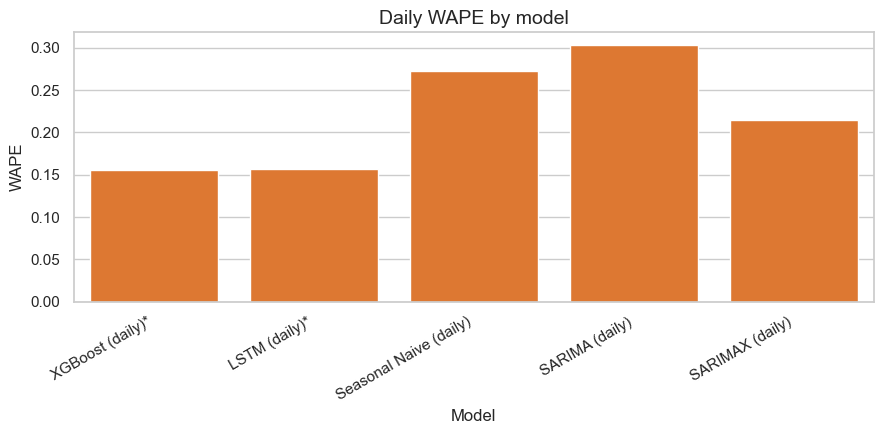

C:\Users\Owner\AppData\Local\Temp\ipykernel_10116\1316049719.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")


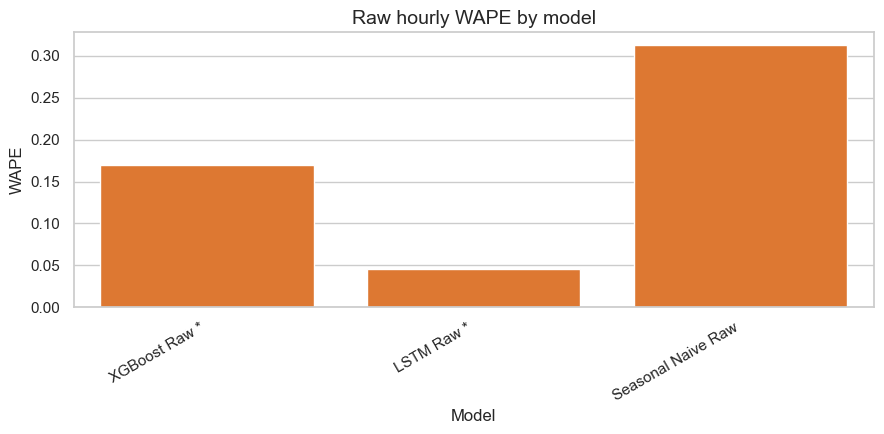

C:\Users\Owner\AppData\Local\Temp\ipykernel_10116\1316049719.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")


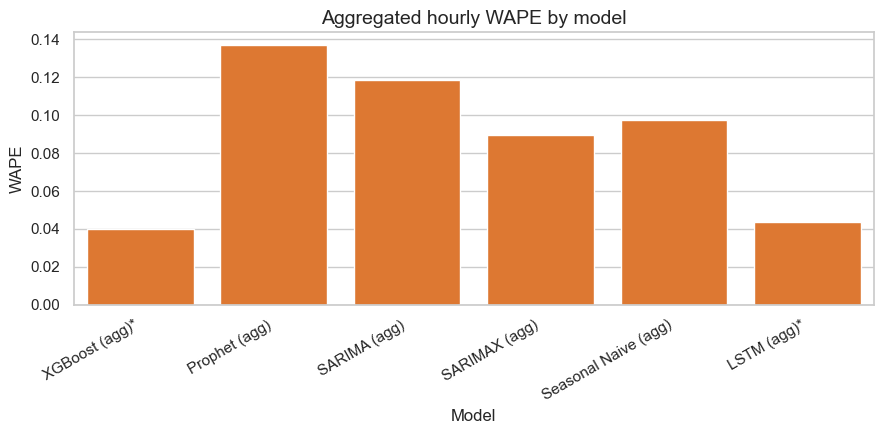

C:\Users\Owner\AppData\Local\Temp\ipykernel_10116\1316049719.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")


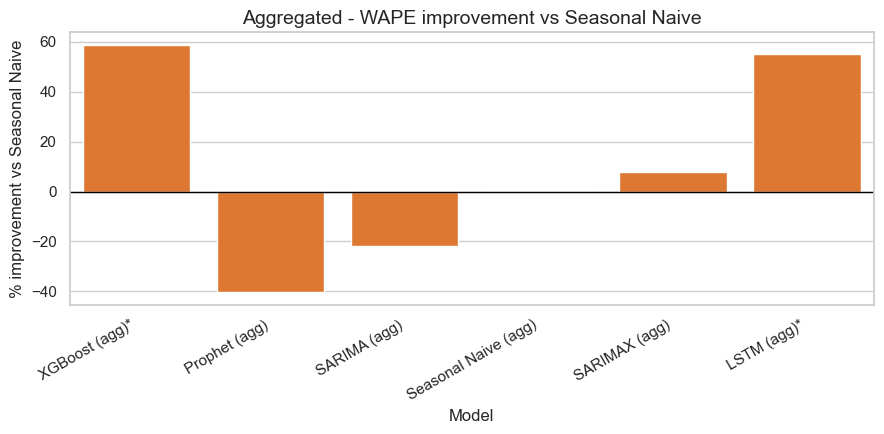

In [23]:

model_metrics = {
    "daily": [
        {"Model": "XGBoost (daily)*", "WAPE": 0.1555},
        {"Model": "LSTM (daily)*", "WAPE": 0.1573},
        {"Model": "Seasonal Naive (daily)", "WAPE": 0.2731},
        {"Model": "SARIMA (daily)", "WAPE": 0.3032},
        {"Model": "SARIMAX (daily)", "WAPE": 0.2147},
    ],
    "raw_hourly": [
        {"Model": "XGBoost Raw *", "WAPE": 0.1703},
        {"Model": "LSTM Raw *", "WAPE": 0.0459},
        {"Model": "Seasonal Naive Raw", "WAPE": 0.3126},
    ],
    "aggregated_hourly": [
        {"Model": "XGBoost (agg)*", "WAPE": 0.0401},
        {"Model": "Prophet (agg)", "WAPE": 0.1369},
        {"Model": "SARIMA (agg)", "WAPE": 0.1186},
        {"Model": "SARIMAX (agg)", "WAPE": 0.0897},
        {"Model": "Seasonal Naive (agg)", "WAPE": 0.0975},
        {"Model": "LSTM (agg)*", "WAPE": 0.0439},
    ],
}

plot_configs = [
    ("Daily WAPE by model", "daily", [
        "XGBoost (daily)*",
        "LSTM (daily)*",
        "Seasonal Naive (daily)",
        "SARIMA (daily)",
        "SARIMAX (daily)",
    ]),
    ("Raw hourly WAPE by model", "raw_hourly", [
        "XGBoost Raw *",
        "LSTM Raw *",
        "Seasonal Naive Raw",
    ]),
    ("Aggregated hourly WAPE by model", "aggregated_hourly", [
        "XGBoost (agg)*",
        "Prophet (agg)",
        "SARIMA (agg)",
        "SARIMAX (agg)",
        "Seasonal Naive (agg)",
        "LSTM (agg)*",
    ]),
]

bar_color = "#f97316"

for title, key, order in plot_configs:
    df_plot = pd.DataFrame(model_metrics[key]).set_index("Model").reindex(order).reset_index()
    plt.figure(figsize=(9, 4.5))
    if sns is not None:
        ax = sns.barplot(data=df_plot, x="Model", y="WAPE", color=bar_color)
    else:
        ax = plt.gca()
        ax.bar(df_plot["Model"], df_plot["WAPE"], color=bar_color)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
    ax.set_ylabel("WAPE")
    ax.set_xlabel("Model")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

agg_df = pd.DataFrame(model_metrics["aggregated_hourly"])
seasonal_wape = float(
    agg_df.loc[agg_df["Model"] == "Seasonal Naive (agg)", "WAPE"].iloc[0]
)
agg_df["pct_improvement"] = (seasonal_wape - agg_df["WAPE"]) / seasonal_wape * 100
order = [
    "XGBoost (agg)*",
    "Prophet (agg)",
    "SARIMA (agg)",
    "Seasonal Naive (agg)",
    "SARIMAX (agg)",
    "LSTM (agg)*",
]
agg_df = agg_df.set_index("Model").reindex(order).reset_index()
plt.figure(figsize=(9, 4.5))
if sns is not None:
    ax = sns.barplot(data=agg_df, x="Model", y="pct_improvement", color=bar_color)
else:
    ax = plt.gca()
    ax.bar(agg_df["Model"], agg_df["pct_improvement"], color=bar_color)
ax.axhline(0, color="black", linewidth=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
ax.set_ylabel("% improvement vs Seasonal Naive")
ax.set_xlabel("Model")
ax.set_title("Aggregated - WAPE improvement vs Seasonal Naive")
plt.tight_layout()
plt.show()
